## Effects of migration and bottleneck on the strength and formation of cyanogenesis clines

In this notebook, I look at the effects of migration rate and population bottlenecks on the strength and proportion of significant positive and negative clines in cyanogenesis. 

**Positive clines** refer to increases in the frequency of HCN across space (relative to the starting population).

**Negative clines** refer to decreases in the frequency of HCN across space (relative to the starting population).

In [1]:
library(plyr)
library(ggplot2)
library(data.table, lib="~/Rpackages")
library(Rmisc, lib = "~/Rpackages")
library(dplyr)
library(broom)

Loading required package: lattice

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#Working directory for datasets varying migration rate and bottleneck proportion
setwd('/scratch/research/projects/trifolium/SEC_Simulation.Evolutionary.Clines/SEC_Data/drift-migration/1D/Mig_Bot_Vary')

#Load datasets that will be used for analyses
datSlopes <- fread('20171106_SlopeSum_Gen_BotMig-Merged_distRev.csv', header = T)
datFreqFirst <- fread('20171106_FreqFirstGen_BotMig-Merged_distRev.csv', header = T)
datSlopes$bot <- as.factor(as.character(datSlopes$bot))
datSlopes$Mig_rate <- as.factor(as.character(datSlopes$Mig_rate))

#Data subsets
datSlopes_GenOne <- subset(datSlopes, seq == "1")
datFreqFirst_bot001_NoMig <- subset(datFreqFirst, bot == "0.01" & Mig_rate == "0")
datFreqFirst_bot02_NoMig <- subset(datFreqFirst, bot == "0.2" & Mig_rate == "0")
datFreqFirst_bot001_HighMig <- subset(datFreqFirst, bot == "0.01" & Mig_rate == "0.05")


#Proportion of simulations with Cyan lost by distance under strong bottlenecks
datPropLost_bot001_NoMig <- datFreqFirst_bot001_NoMig %>%
    group_by(Distance) %>%
    summarize(n = n(),
             Lost_001 = sum(Cyan == 0) / n,
             Fixed_001 = sum(Cyan == 1) / n)
datPropLost_bot001_NoMig <- dplyr::select(datPropLost_bot001_NoMig, Distance, 
                                          Lost_001)


#Proportion of simulations with Cyan lost by distance under intermediate bottlenecks
datPropLost_bot02_NoMig <- datFreqFirst_bot02_NoMig %>%
    group_by(Distance) %>%
    summarize(n = n(),
             Lost_02 = sum(Cyan == 0) / n,
             Fixed_02 = sum(Cyan == 1) / n)
datPropLost_bot02_NoMig <- dplyr::select(datPropLost_bot02_NoMig, Distance, 
                                          Lost_02)

#Merge datasets from strong and intermediate bottlenecks above
datPropLost_merged <- merge(datPropLost_bot001_NoMig, datPropLost_bot02_NoMig)


#Melt above dataset above into long form for plotting
datPropLost_NoMig_melted <- melt(datPropLost_merged, id.vars = "Distance", variable.name = "bot", 
            value.name = "Proportion")
datPropLost_NoMig_melted <- within(datPropLost_NoMig_melted, {
    bot = ifelse(bot == "Lost_001", "0.01", "0.02")
})

#Datasets to compare regression slopes of clines where HCN is quickly lost (e.g. when bottlenecks are strong)
#to those where HCN is not lost (e.g. intermediate bottleneck)
datLostAt2 <- datFreqFirst_bot001_NoMig %>%
    filter(Sim == 12)
datNotLost <- datFreqFirst_bot02_NoMig %>%
    filter(Sim == 865)

#Proportion of simulations with Cyan lost by distance under strong bottlenecks WITH migration
datPropLost_bot001_HighMig <- datFreqFirst_bot001_HighMig %>%
    group_by(Distance) %>%
    summarize(n = n(),
             Lost = sum(Cyan == 0) / n,
             Fixed = sum(Cyan == 1) / n)

#Melted for plotting
datPropLost_bot001_HighMig <- dplyr::select(datPropLost_bot001_HighMig, Distance, 
                                          Lost, Fixed)
datPropLost_bot001_HighMig_melted <- melt(datPropLost_bot001_HighMig, id.vars = "Distance", variable.name = "Fate", 
            value.name = "Proportion")

Read 1200000 rows and 12 (of 12) columns from 0.046 GB file in 00:00:09


In [6]:
str(datSlopes_GenOne)

Classes ‘data.table’ and 'data.frame':	30 obs. of  20 variables:
 $ bot        : Factor w/ 10 levels "0.01","0.025",..: 1 1 1 2 2 2 3 3 3 4 ...
 $ Mig_rate   : Factor w/ 3 levels "0","0.01","0.05": 1 2 3 1 2 3 1 2 3 1 ...
 $ seq        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ mean       : num  0.00151 0.0019 0.00151 0.00212 0.00315 ...
 $ sd         : num  0.00381 0.00532 0.0038 0.00548 0.00661 ...
 $ n          : int  1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 ...
 $ se         : num  0.000121 0.000168 0.00012 0.000173 0.000209 ...
 $ ci_mean    : num  0.000236 0.00033 0.000236 0.00034 0.000409 ...
 $ prop_sigPos: num  0.421 0.525 0.491 0.607 0.64 0.48 0.665 0.656 0.494 0.718 ...
 $ prop_pos   : num  0.74 0.732 0.71 0.748 0.753 0.707 0.763 0.742 0.695 0.757 ...
 $ se_pos     : num  0.0139 0.014 0.0143 0.0137 0.0136 ...
 $ ci_pos     : num  0.0272 0.0275 0.0281 0.0269 0.0267 ...
 $ se_sigPos  : num  0.0156 0.0158 0.0158 0.0154 0.0152 ...
 $ ci_sigPos  : num  0.0306 0.031 0.031 0.0303 0

In [3]:
#Themes used for plotting
ng1=theme(aspect.ratio=0.7,panel.background = element_blank(), 
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.border=element_blank(),
          axis.line.x = element_line(color="black",size=1), 
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(color="black"), 
          axis.text=element_text(color="black",size=15), 
          axis.title=element_text(color="black",size=1), 
          axis.title.y=element_text(vjust=2,face="bold",size=15),
          axis.title.x=element_text(vjust=0.1,face="bold",size=15),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          legend.position = "right", legend.direction="vertical", 
          legend.text=element_text(size=11), legend.key = element_rect(fill = "white"), 
          legend.title = element_text(size=13,face="bold"),legend.key.size = unit(0.5, "cm"))

ng1.45=theme(aspect.ratio=0.7,panel.background = element_blank(), 
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          panel.border=element_blank(),
          axis.line.x = element_line(color="black",size=1), 
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(color="black"), 
          axis.text=element_text(color="black",size=15), 
          axis.title=element_text(color="black",size=1), 
          axis.title.y=element_text(vjust=2,face="bold",size=15),
          axis.title.x=element_text(vjust=0.1,face="bold",size=15),
          axis.text.x=element_text(size=13,angle=45,hjust=1),
          axis.text.y=element_text(size=13),
          legend.position = "right", legend.direction="vertical", 
          legend.text=element_text(size=11), legend.key = element_rect(fill = "white"), 
          legend.title = element_text(size=13,face="bold"),legend.key.size = unit(0.5, "cm"))

In [10]:
path = "/scratch/research/projects/trifolium/SEC_Simulation.Evolutionary.Clines/SEC_Sync/SEC_Figures/Drift.Migration/Mig_Bot_Vary"

# ggsave("Mean-slope_BotMig.pdf", plot = MeanSlope_BotMig, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
# ggsave("PropSigPos_BotMig.pdf", plot = PropSigPos_BotMig, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
# ggsave("propLost_bot_NoMig.pdf", plot = propLost_bot_NoMig, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
# ggsave("Regression_LostAtGen2_Bot001_NpMig.pdf", plot = LostAt2_bot001_NoMig, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
# ggsave("Regression_NotLost_Bot02_NoMig.pdf", plot = NotLost_bot02_NoMig, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
# ggsave("PropNeg_BotMig.pdf", plot = PropNeg_BotMig, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
ggsave("Mean-slope_Bot_HighMig.pdf", plot = MeanSlope_Bot_HighMig, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
ggsave("PropSigPos_Bot_HighMig.pdf", plot = PropPos_Bot_HighMig, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)

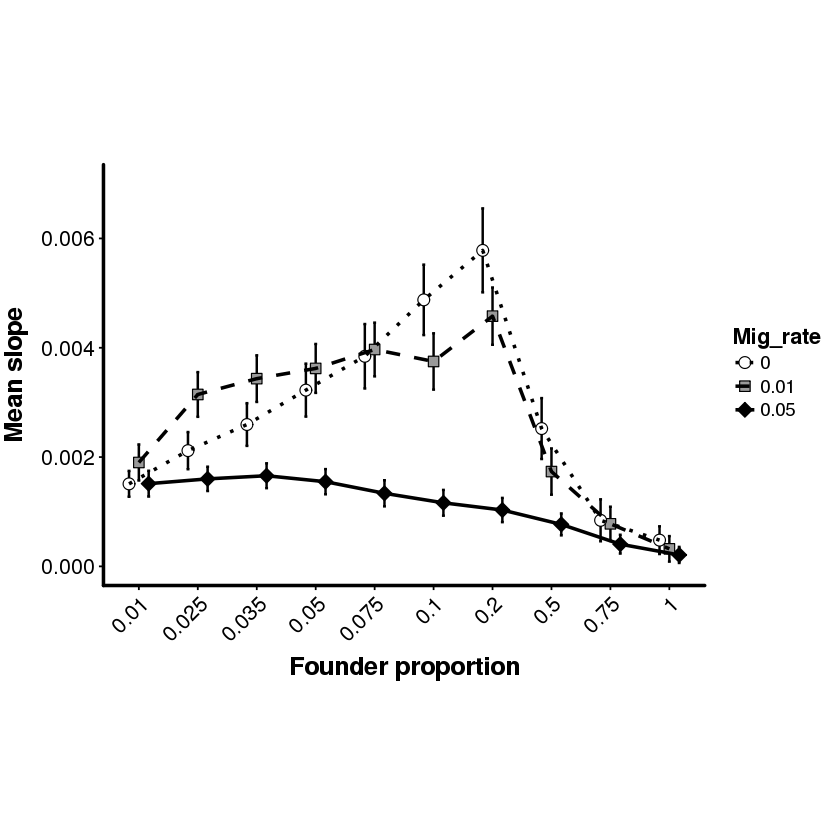

In [13]:
MeanSlope_BotMig <- ggplot(datSlopes_GenOne, aes(x = bot, y = mean, group = Mig_rate)) + 
    geom_errorbar(aes(ymin = mean - ci_mean, ymax = mean + ci_mean), width=0.15, size=0.7,
    position = position_dodge(width = 0.5)) +
    geom_point(size = 3, aes(fill = Mig_rate, shape = Mig_rate), position = position_dodge(width = 0.5)) + 
    geom_line(size = 1, aes(linetype = Mig_rate), position = position_dodge(width = 0.5)) +
    scale_shape_manual(labels = c("0", "0.01", "0.05"), values = c(21, 22, 23)) +
    scale_fill_manual(labels = c("0", "0.01", "0.05"), values = c("white", "grey60", "black")) +
    scale_linetype_manual(labels = c("0", "0.01", "0.05"), values = c("dotted", "dashed", "solid")) +  
    coord_cartesian(ylim = c(0, 0.007)) + scale_y_continuous(breaks = seq(from = 0, to = 0.006, by = 0.002)) +
    ylab("Mean slope") + xlab("Founder proportion") + ng1.45
MeanSlope_BotMig + ng1.45

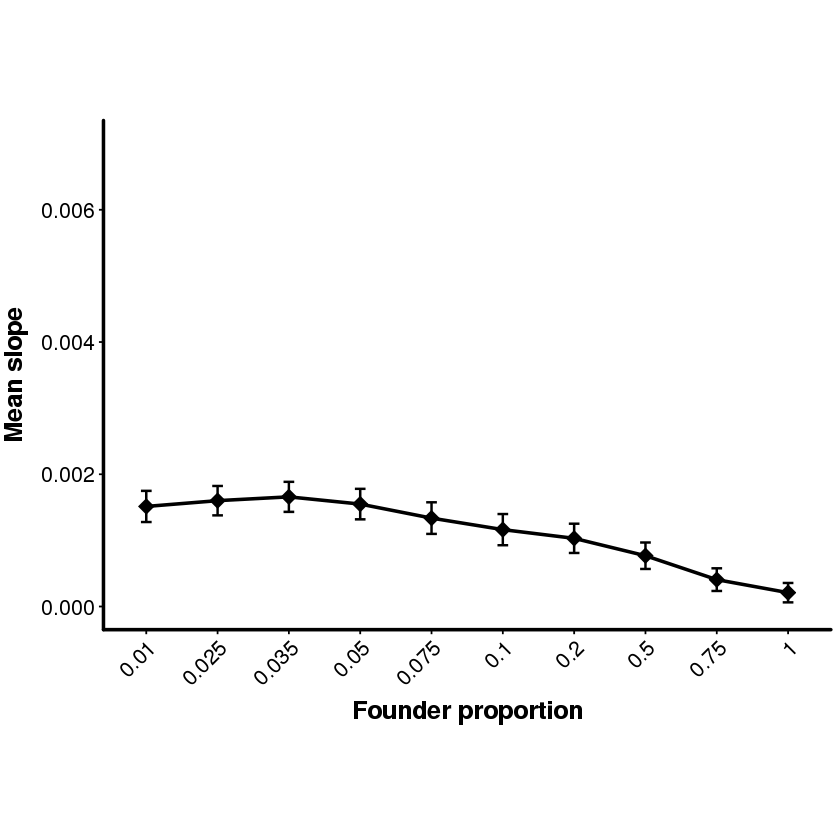

In [12]:
high_mig_only <- subset(datSlopes_GenOne, Mig_rate == 0.05)
MeanSlope_Bot_HighMig <- ggplot(high_mig_only, aes(x = bot, y = mean, group = Mig_rate)) + 
    geom_errorbar(aes(ymin = mean - ci_mean, ymax = mean + ci_mean), width=0.15, size=0.7,
    position = position_dodge(width = 0.5)) +
    geom_point(size = 3, position = position_dodge(width = 0.5), shape = 23, fill = "black") + 
    geom_line(size = 1, position = position_dodge(width = 0.5)) +
    coord_cartesian(ylim = c(0, 0.007)) + scale_y_continuous(breaks = seq(from = 0, to = 0.006, by = 0.002)) +
    ylab("Mean slope") + xlab("Founder proportion") + ng1.45
MeanSlope_Bot_HighMig + ng1.45

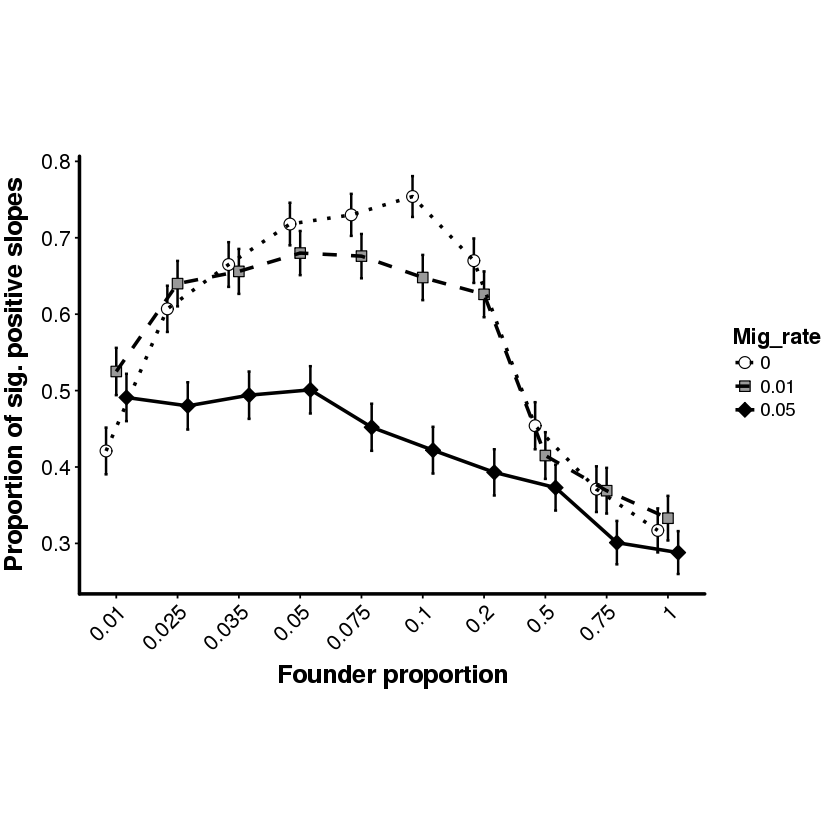

In [8]:
PropSigPos_BotMig <- ggplot(datSlopes_GenOne, aes(x = bot, y = prop_sigPos, group = Mig_rate)) + 
    geom_errorbar(aes(ymin = prop_sigPos - ci_sigPos, ymax = prop_sigPos + ci_sigPos), width=0.15, size=0.7,
    position = position_dodge(width = 0.5)) +
    geom_point(size = 3, aes(fill = Mig_rate, shape = Mig_rate), position = position_dodge(width = 0.5)) + 
    geom_line(size = 1, aes(linetype = Mig_rate), position = position_dodge(width = 0.5)) +
    scale_shape_manual(labels = c("0", "0.01", "0.05"), values = c(21, 22, 23)) +
    scale_fill_manual(labels = c("0", "0.01", "0.05"), values = c("white", "grey60", "black")) +
    scale_linetype_manual(labels = c("0", "0.01", "0.05"), values = c("dotted", "dashed", "solid")) +    
    ylab("Proportion of sig. positive slopes") + xlab("Founder proportion")+ ng1.45
PropSigPos_BotMig + ng1.45

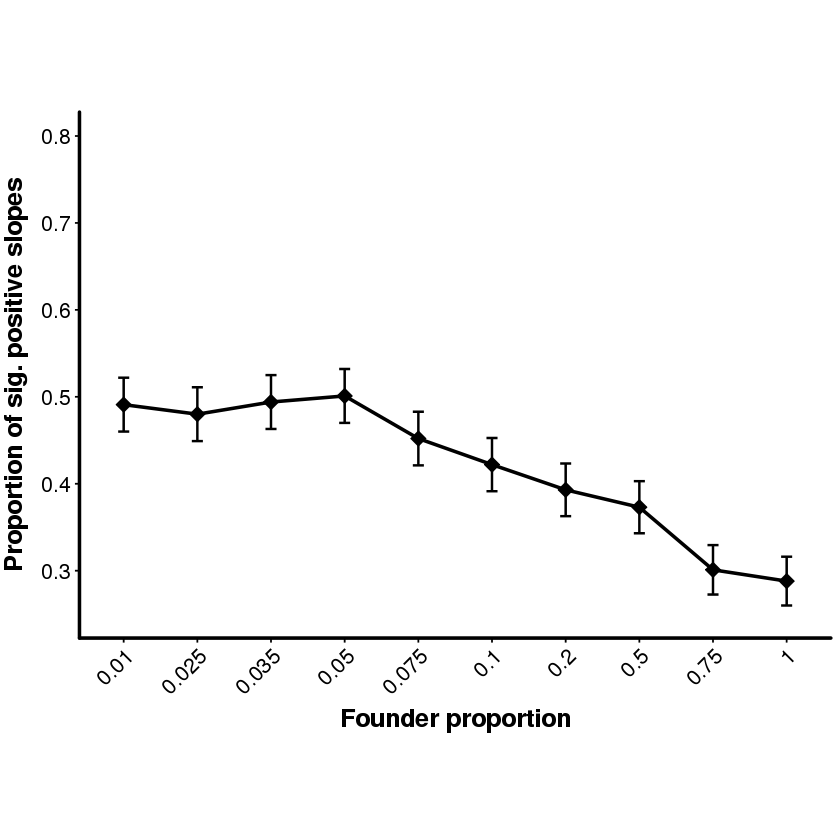

In [15]:
PropPos_Bot_HighMig <- ggplot(high_mig_only, aes(x = bot, y = prop_sigPos, group = Mig_rate)) + 
    geom_errorbar(aes(ymin = prop_sigPos - ci_sigPos, ymax = prop_sigPos + ci_sigPos), width=0.15, size=0.7,
    position = position_dodge(width = 0.5)) +
    geom_point(size = 3, position = position_dodge(width = 0.5), shape = 23, fill = "black") + 
    geom_line(size = 1, position = position_dodge(width = 0.5)) +
    coord_cartesian(ylim = c(0.25, 0.8)) + scale_y_continuous(breaks = seq(from = 0.3, to = 0.8, by = 0.1)) +
    ylab("Proportion of sig. positive slopes") + xlab("Founder proportion") + ng1.45
PropPos_Bot_HighMig + ng1.45

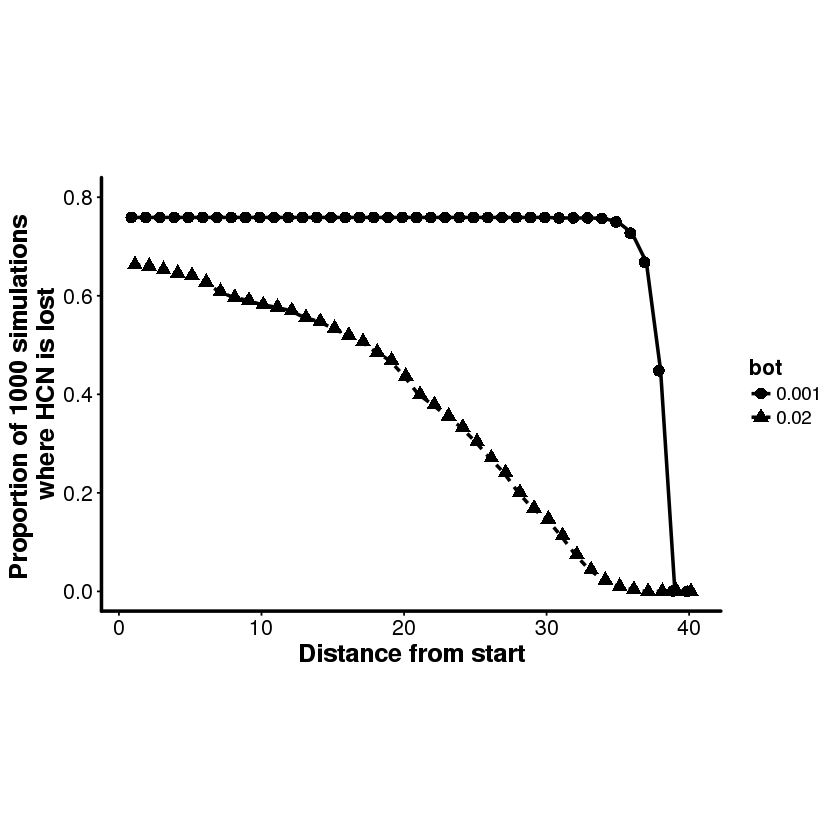

In [5]:
propLost_bot_NoMig <- ggplot(datPropLost_NoMig_melted, aes(x = Distance, y = Proportion, group = bot)) + 
    geom_point(size = 3, aes(fill = bot, shape = bot), position = position_dodge(width = 0.5)) +
    geom_line(size = 1, aes(linetype = bot)) +
    ylab("Proportion of 1000 simulations 
where HCN is lost") + xlab("Distance from start") +
    coord_cartesian(ylim = c(0, 0.8)) + scale_y_continuous(breaks = seq(from = 0, to = 0.8, by = 0.2)) + ng1
propLost_bot_NoMig + ng1

In [4]:
LostAt2_lm <- lm(Cyan ~ Distance, data = datLostAt2)
summary(LostAt2_lm)


Call:
lm(formula = Cyan ~ Distance, data = datLostAt2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.06230 -0.03741 -0.01252  0.01237  0.49560 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.034704   0.028150  -1.233   0.2252  
Distance     0.002553   0.001197   2.133   0.0394 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08736 on 38 degrees of freedom
Multiple R-squared:  0.107,	Adjusted R-squared:  0.08346 
F-statistic: 4.551 on 1 and 38 DF,  p-value: 0.03941


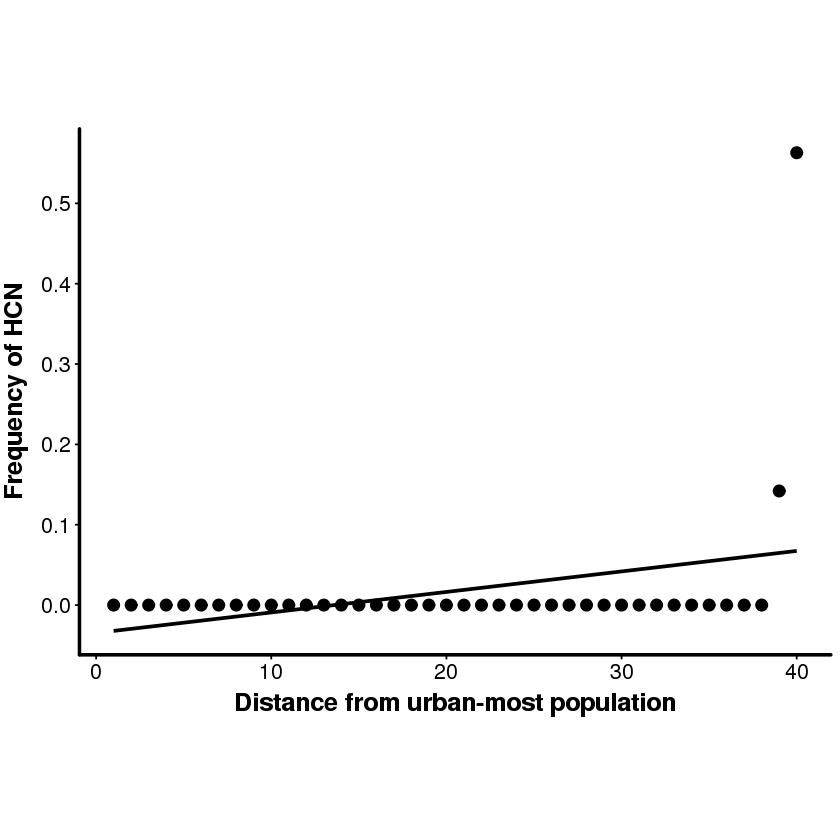

In [7]:
LostAt2_bot001_NoMig <- ggplot(datLostAt2, aes(x = Distance, y = Cyan)) + 
    geom_point(size = 3) +
    geom_smooth(method = "lm", se = F, colour = "black", size = 1.05) +
    ylab("Frequency of HCN") + xlab("Distance from urban-most population") + 
    scale_y_continuous(breaks = seq(from = 0, to = 0.5, by = 0.1)) + ng1
LostAt2_bot001_NoMig

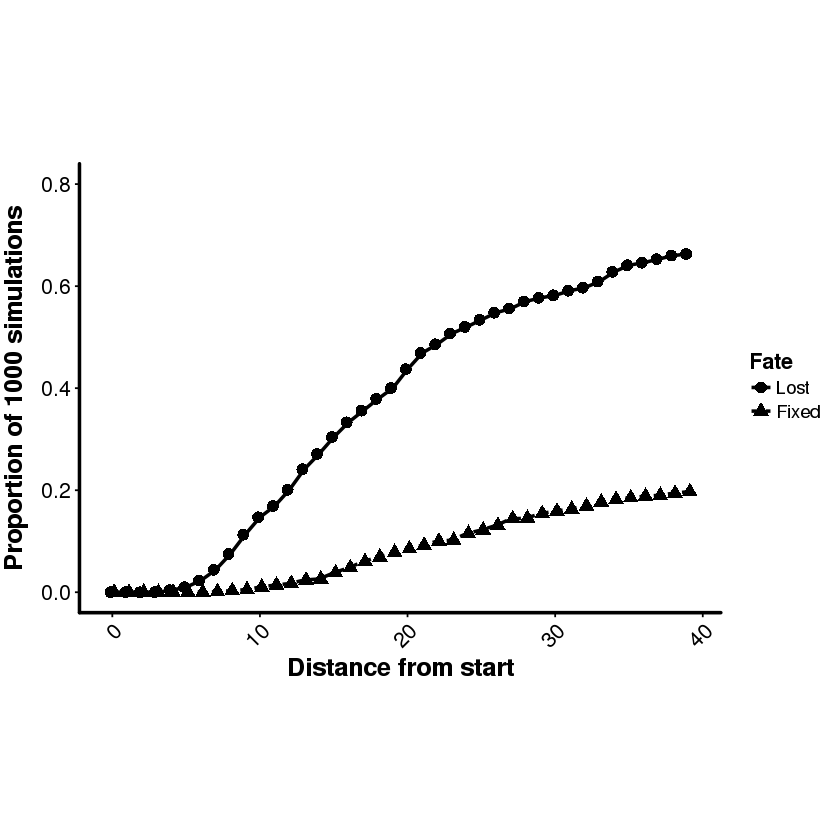

In [22]:
propFixedLost_bot02_NoMig <- ggplot(datPropLost_bot02_NoMig_melted, aes(x = Distance, y = Proportion, group = Fate)) + 
    geom_point(size = 3, aes(fill = Fate, shape = Fate), position = position_dodge(width = 0.5)) +
    geom_line(size = 1, aes(linetype = Fate)) +
    ylab("Proportion of 1000 simulations") + xlab("Distance from urban-most population") +
    coord_cartesian(ylim = c(0, 0.8)) + scale_y_continuous(breaks = seq(from = 0, to = 0.8, by = 0.2)) + ng1.45
propFixedLost_bot02_NoMig + ng1

In [6]:
NotLost_lm <- lm(Cyan ~ Distance, data = datNotLost)
summary(NotLost_lm)


Call:
lm(formula = Cyan ~ Distance, data = datNotLost)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.23586 -0.13550 -0.04922  0.13309  0.32154 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.246104   0.053613   4.590 4.73e-05 ***
Distance    0.012235   0.002279   5.369 4.17e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1664 on 38 degrees of freedom
Multiple R-squared:  0.4314,	Adjusted R-squared:  0.4164 
F-statistic: 28.83 on 1 and 38 DF,  p-value: 4.171e-06


In [13]:
(0.012235 - 0.002553)/0.002553

[1] 3.792401

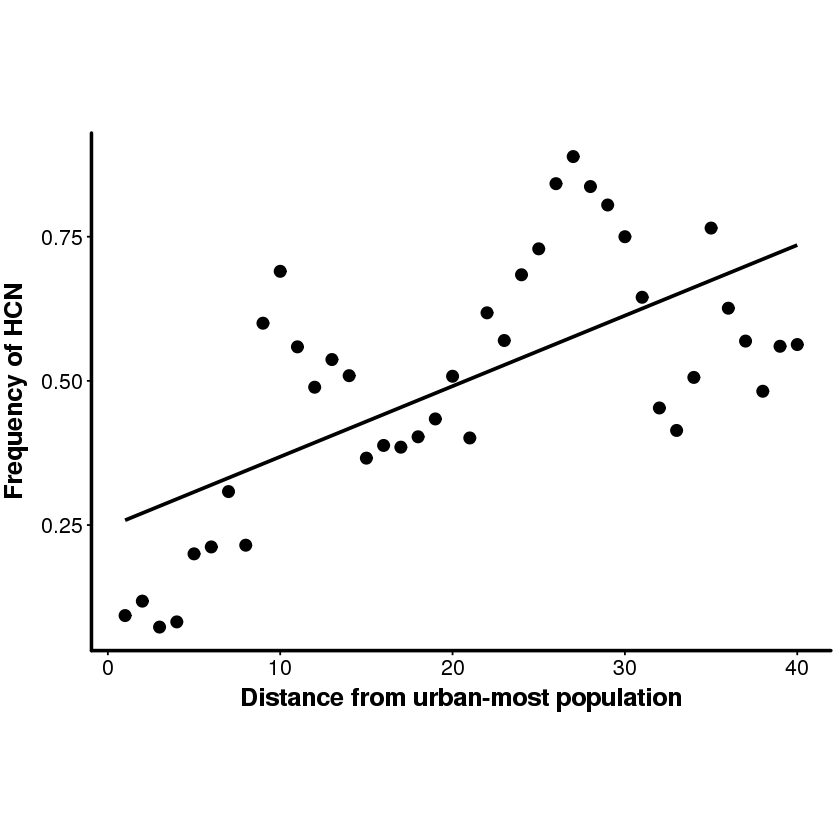

In [9]:
NotLost_bot02_NoMig <- ggplot(datNotLost, aes(x = Distance, y = Cyan)) + 
    geom_point(size = 3) +
    geom_smooth(method = "lm", se = F, colour = "black", size = 1.05) +
    ylab("Frequency of HCN") + xlab("Distance from urban-most population") + ng1
NotLost_bot02_NoMig + ng1

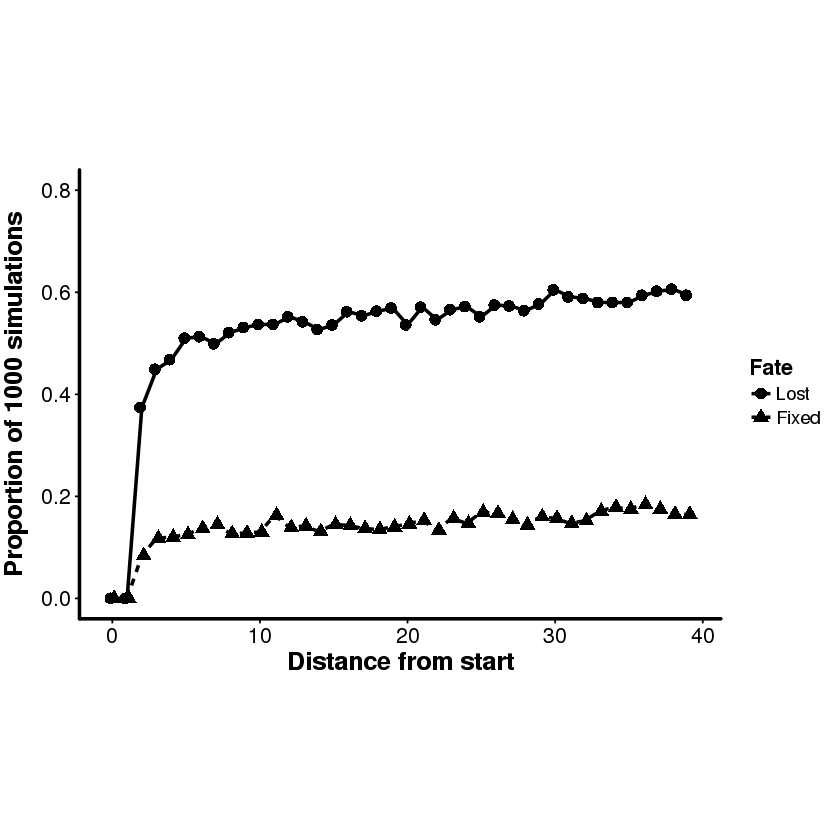

In [15]:
propFixedLost_bot001_HighMig <- ggplot(datPropLost_bot001_HighMig_melted, aes(x = Distance, y = Proportion, group = Fate)) + 
    geom_point(size = 3, aes(fill = Fate, shape = Fate), position = position_dodge(width = 0.5)) +
    geom_line(size = 1, aes(linetype = Fate)) +
    ylab("Proportion of 1000 simulations") + xlab("Distance from start") +
    coord_cartesian(ylim = c(0, 0.8)) + scale_y_continuous(breaks = seq(from = 0, to = 0.8, by = 0.2))
propFixedLost_bot001_HighMig + ng1

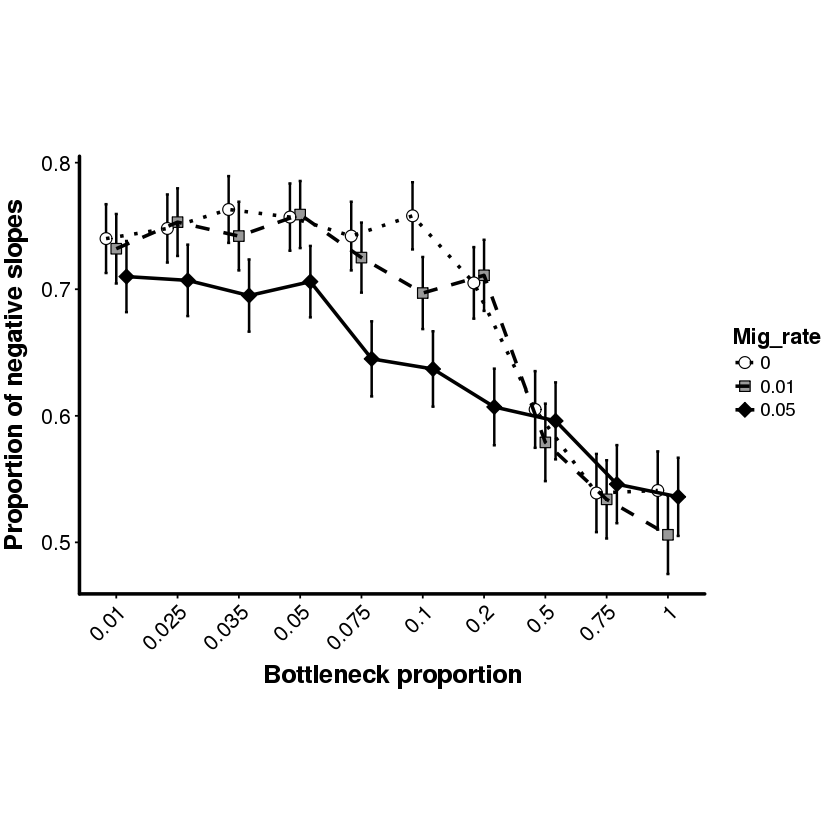

In [41]:
PropNeg_BotMig <- ggplot(datSlopes_GenOne, aes(x = bot, y = prop_neg, group = Mig_rate)) + 
    geom_errorbar(aes(ymin = prop_neg - ci_neg, ymax = prop_neg + ci_neg), width=0.15, size=0.7,
    position = position_dodge(width = 0.5)) +
    geom_point(size = 3, aes(fill = Mig_rate, shape = Mig_rate), position = position_dodge(width = 0.5)) + 
    geom_line(size = 1, aes(linetype = Mig_rate), position = position_dodge(width = 0.5)) +
    scale_shape_manual(labels = c("0", "0.01", "0.05"), values = c(21, 22, 23)) +
    scale_fill_manual(labels = c("0", "0.01", "0.05"), values = c("white", "grey60", "black")) +
    scale_linetype_manual(labels = c("0", "0.01", "0.05"), values = c("dotted", "dashed", "solid")) +    
    ylab("Proportion of negative slopes") + xlab("Bottleneck proportion") + ng1.45
PropNeg_BotMig + ng1.45

In [65]:
#Extra columns that will be used to create melting dataset for plotting proportion of positive and negative slopes
Bot_SlopeSum_Melt_NoMig <- dplyr::select(dat_GenOne_NoMig, bot, prop_sigPos, ci.lower.Pos, ci.upper.Pos, prop_sigNeg,
  ci.lower.Neg, ci.upper.Neg)

#Melt dataframe
dm1 <- melt(dat_GenOne_NoMig[,c("bot", "prop_sigPos", "ci.lower.Pos", "ci.upper.Pos")], 
            id=c("bot", "ci.lower.Pos", "ci.upper.Pos"))
dm2 <- melt(dat_GenOne_NoMig[,c("bot", "prop_sigNeg", "ci.lower.Neg", "ci.upper.Neg")], 
            id=c("bot", "ci.lower.Neg", "ci.upper.Neg"))

#Rename columns
setnames(dm1, old = c("ci.lower.Pos", "ci.upper.Pos"), new = c("ci.lower", "ci.upper"))
setnames(dm2, old = c("ci.lower.Neg", "ci.upper.Neg"), new = c("ci.lower", "ci.upper"))

#Merge melted dataframes
Bot_SlopeSum_Melt_NoMig <- rbind(dm1, dm2)
Bot_SlopeSum_Melt_NoMig

bot,ci.lower,ci.upper,variable,value
0.010,0.02360348,0.02360348,prop_sigPos,0.176
0.025,0.02604360,0.02604360,prop_sigPos,0.229
0.035,0.02608347,0.02608347,prop_sigPos,0.230
0.050,0.02647089,0.02647089,prop_sigPos,0.240
0.075,0.02704970,0.02704970,prop_sigPos,0.256
0.100,0.02643305,0.02643305,prop_sigPos,0.239
0.200,0.02687409,0.02687409,prop_sigPos,0.251
0.500,0.02809570,0.02809570,prop_sigPos,0.289
0.750,0.02818150,0.02818150,prop_sigPos,0.292
1.000,0.02761243,0.02761243,prop_sigPos,0.273


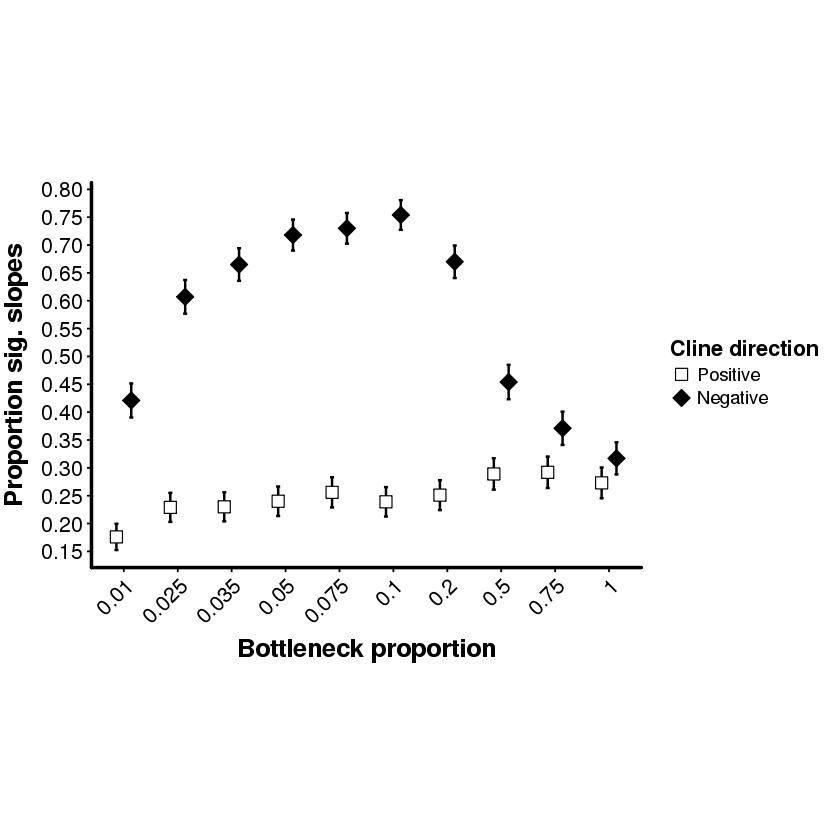

In [68]:
#Plot proportion of significant slopes by migration rate
PropSig_Bot_NoMig <- ggplot(Bot_SlopeSum_Melt_NoMig, aes(x = factor(bot), y = value, 
    shape = variable, fill = variable)) + 
    geom_errorbar(aes(ymin = value - ci.lower, ymax = value + ci.upper), width=0.15, size = 0.7, 
    position = position_dodge(width = 0.55)) +
    ylab("Proportion sig. slopes") + xlab("Bottleneck proportion") + geom_point(size = 3.5, color = "black", 
    position = position_dodge(width = 0.55)) +
    scale_shape_manual(labels = c("Positive", "Negative"),values=c(22, 23))+
    scale_fill_manual(labels = c("Positive", "Negative"),values=c("white", "black")) +
    scale_y_continuous(breaks = seq(from = 0, to = 1.0, by = 0.05)) +
    labs(shape = 'Cline direction', fill = 'Cline direction')
PropSig_Bot_NoMig + ng1.45

Warning message:
“Removed 1 rows containing missing values (geom_vline).”

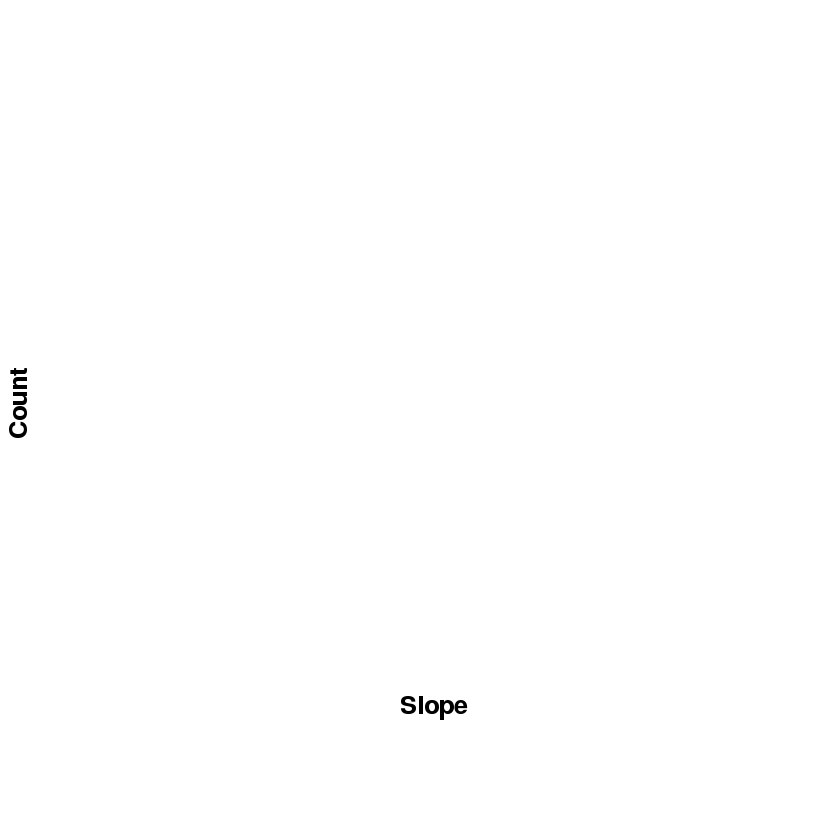

In [27]:
Bot_slopes_1 <- subset(Bot_slopes, bot == 1.0)

mean  <-  mean(Bot_slopes_1$estimate)

path = "/scratch/research/projects/trifolium/SEC_Simulation.Evolutionary.Clines/SEC_Sync/SEC_Figures/Drift.Migration/Mig_Bot_Vary"

phist_1_all <- ggplot(Bot_slopes_1,aes(x=estimate)) +
    geom_histogram(fill = "white", color = "black") + 
    geom_vline(aes(xintercept = mean), colour="black", linetype = "dashed") +
#     coord_cartesian(ylim = c(0, 45000)) +
#     scale_y_continuous(breaks = seq(from = 0, to = 45000, by = 10000), expand = c(0, 0)) +
    xlab("Slope") + ylab("Count") +
    ng1
phist_1_all

# ggsave("Slopes_hist_1.0_all.pdf", plot = phist_1_all, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)


### Mean slope by migration rate and bottleneck strength. Averaged across all generations where the matrix is full and across all 1000 simulations

The following two plots show the effect of migration rate and population bottlenecks on the mean slope of clines. Means were calculated by averaging across all 1000 simulations and only include slopes calculated from models when the matrix (50 cells) was filled. 

#### Main results

1. Increasing migration rates result in weaker clines (i.e. slopes getting closer to 0). *Notice the weird result at m = 0.0025. Note quite sure what is going on here.*
2. Stronger population bottlenecks (e.g. bottleneck = 0.0025) result in stronger clines. *Notice weird result at bottleneck = 0.001. I suspect I know what is going on here and it relates to the fact that these are average values and the matrix did not fill in many simulations because of the strong reduction in population size under strong bottlenecks. Remember that the probability of crating populations decreaases with decreasing population size.*

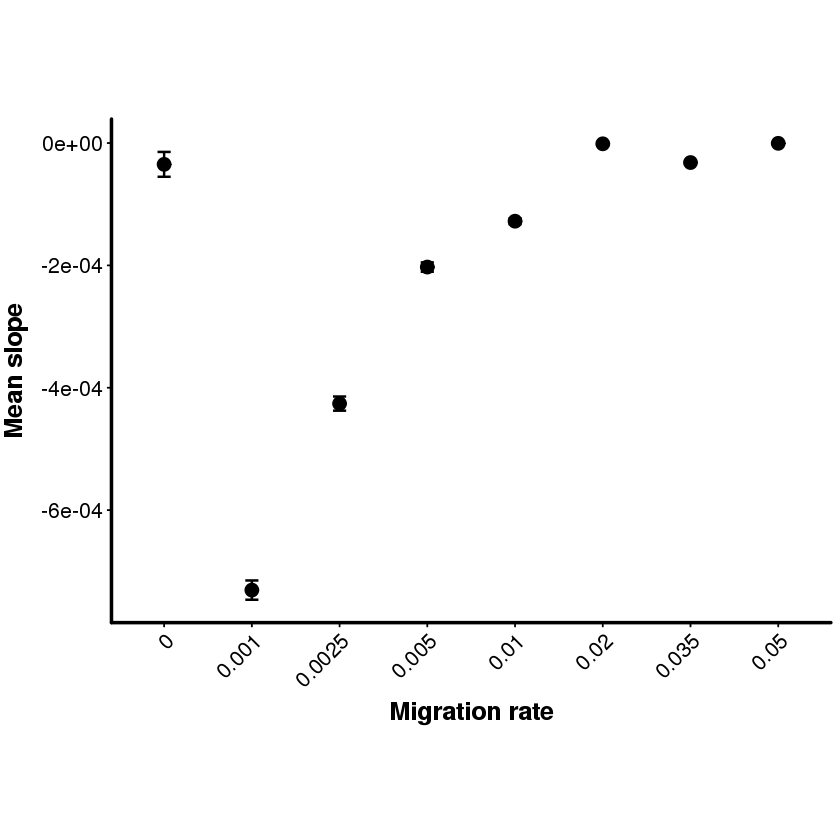

In [31]:
plotMeanSlope_Mig_rate <- ggplot(MigRate_SlopeSum, aes(x = factor(Mig_rate), y = mean)) + 
    geom_errorbar(aes(ymin = mean - ci.lower, ymax = mean + ci.upper), width=0.15, size=0.7,
    position = position_dodge(width = 0.5)) +
    ylab("Mean slope") + xlab("Migration rate") + geom_point(size = 3.5, color = "black") 
plotMeanSlope_Mig_rate + ng1.45

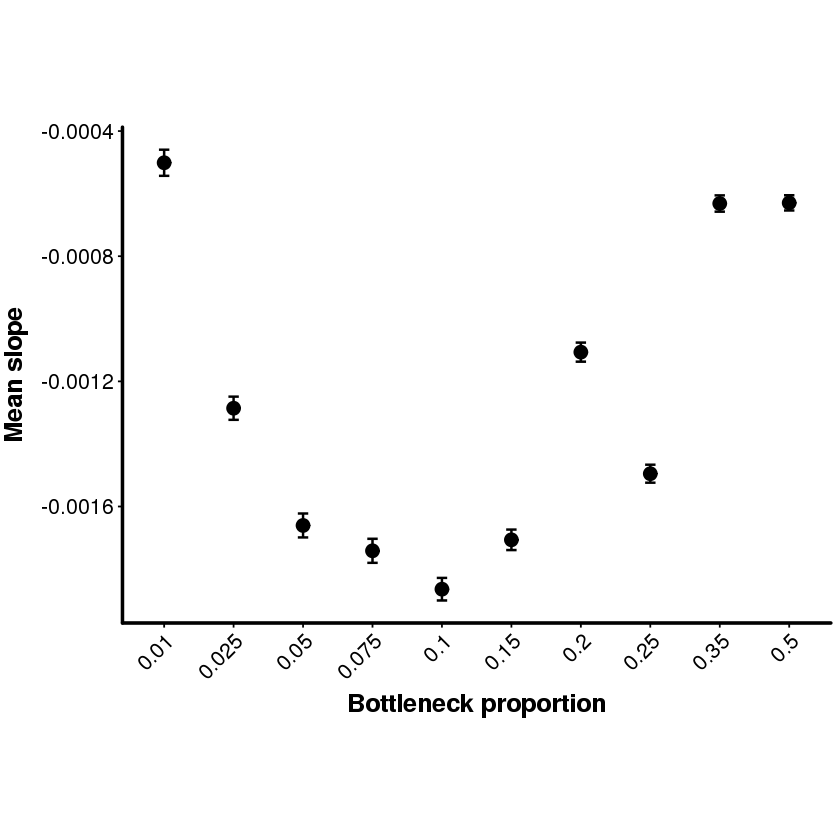

In [32]:
plotMeanSlope_Bot_rate <- ggplot(Bot_SlopeSum, aes(x = factor(bot), y = mean)) + 
    geom_errorbar(aes(ymin = mean - ci.lower, ymax = mean + ci.upper), width=0.15, size=0.7,
    position = position_dodge(width = 0.5))+
    ylab("Mean slope") + xlab("Bottleneck proportion") + geom_point(size = 3.5, color = "black") 
plotMeanSlope_Bot_rate + ng1.45

### Proportion of significantly positive and negative clines. Averaged across all generations where the matrix is full and across all 1000 simulations

The following two plots show the effect of migration and population bottlenecks on the proportion of significant cyanogenesis clines (both positive and negative). Proportions were calculated across all 1000 simulations and only include clines calculated from models when the matrix (50 cells) was filled.

#### Main results

1. The proportion of significant clines decreases with increasing migration. 
2. For migration rates that do not swamp out clines (i.e. m < 0.02), the proportion of significant negative clines (i.e. loss of HCN across space) is always greater than the proportion of significantly positive clines (i.e. increase in HCN across space). 
3. Stronger population bottlenecks are associated with a greater proportion of significant clines. However, this only seems to be true for negative clines; the proportion of significantly positive clines shows little change (a bit of a hump-shaped curve...greatest proportion at intermediate migration rates??). 

In [8]:
#Extra columns that will be used to create melting dataset for plotting proportion of positive and negative slopes
MigRate_SlopeSum_Melt <- dplyr::select(MigRate_SlopeSum, Mig_rate, prop_sigPos, ci.lower.Pos, ci.upper.Pos, prop_sigNeg,
  ci.lower.Neg, ci.upper.Neg)

#Melt dataframe
dm1 <- melt(MigRate_SlopeSum_Melt[,c("Mig_rate", "prop_sigPos", "ci.lower.Pos", "ci.upper.Pos")], 
            id=c("Mig_rate", "ci.lower.Pos", "ci.upper.Pos"))
dm2 <- melt(MigRate_SlopeSum_Melt[,c("Mig_rate", "prop_sigNeg", "ci.lower.Neg", "ci.upper.Neg")], 
            id=c("Mig_rate", "ci.lower.Neg", "ci.upper.Neg"))

#Rename columns
setnames(dm1, old = c("ci.lower.Pos", "ci.upper.Pos"), new = c("ci.lower", "ci.upper"))
setnames(dm2, old = c("ci.lower.Neg", "ci.upper.Neg"), new = c("ci.lower", "ci.upper"))

#Merge melted dataframes
MigRate_SlopeSum_Melt <- rbind(dm1, dm2)
MigRate_SlopeSum_Melt

Mig_rate,ci.lower,ci.upper,variable,value
0.0000,0.0011512364,0.0011512364,prop_sigPos,0.22625342
0.0010,0.0010378293,0.0010378293,prop_sigPos,0.17335092
0.0025,0.0009657974,0.0009657974,prop_sigPos,0.14527600
0.0050,0.0008148163,0.0008148163,prop_sigPos,0.09723395
0.0100,0.0006166626,0.0006166626,prop_sigPos,0.05332358
0.0200,0.0005319848,0.0005319848,prop_sigPos,0.03907905
0.0350,0.0004772868,0.0004772868,prop_sigPos,0.03126609
0.0500,0.0004965382,0.0004965382,prop_sigPos,0.03373978
0.0000,0.0012362486,0.0012362486,prop_sigNeg,0.28061943
0.0010,0.0012191871,0.0012191871,prop_sigNeg,0.27143701


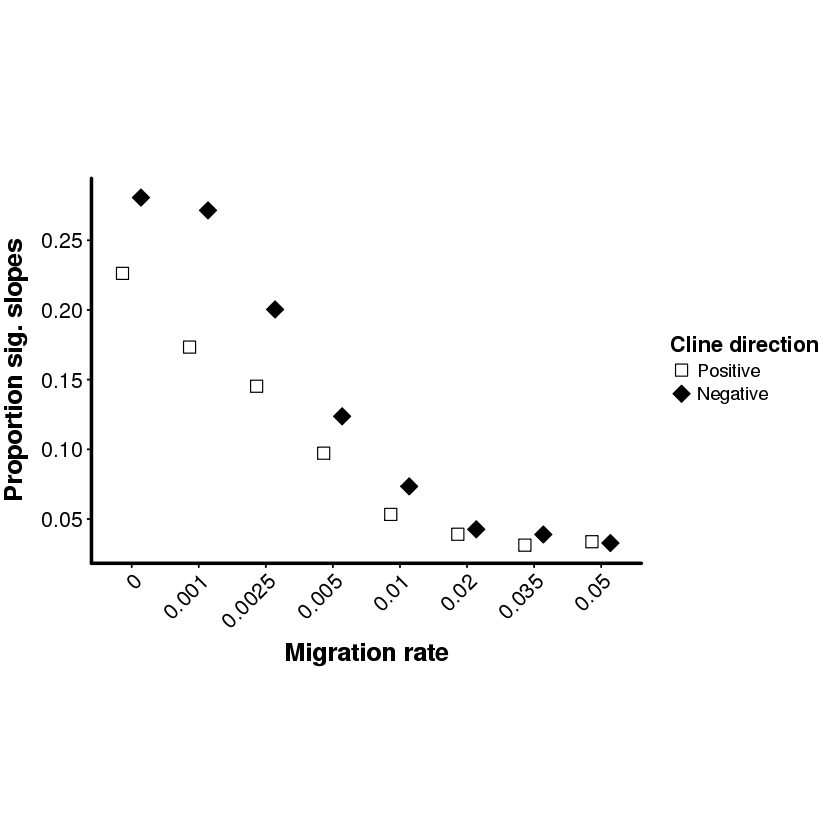

In [9]:
#Plot proportion of significant slopes by migration rate
plotPropSlope_Mig_rate <- ggplot(MigRate_SlopeSum_Melt, aes(x = factor(Mig_rate), y = value, 
    shape = variable, fill = variable)) + 
    geom_errorbar(aes(ymin = value - ci.lower, ymax = value + ci.upper), width=0.15, size = 0.7, 
    position = position_dodge(width = 0.55)) +
    ylab("Proportion sig. slopes") + xlab("Migration rate") + geom_point(size = 3.5, color = "black", 
    position = position_dodge(width = 0.55)) +
    scale_shape_manual(labels = c("Positive", "Negative"),values=c(22, 23))+
    scale_fill_manual(labels = c("Positive", "Negative"),values=c("white", "black")) +
    scale_y_continuous(breaks = seq(from = 0, to = 0.30, by = 0.05)) +
    labs(shape = 'Cline direction', fill = 'Cline direction')
plotPropSlope_Mig_rate + ng1.45

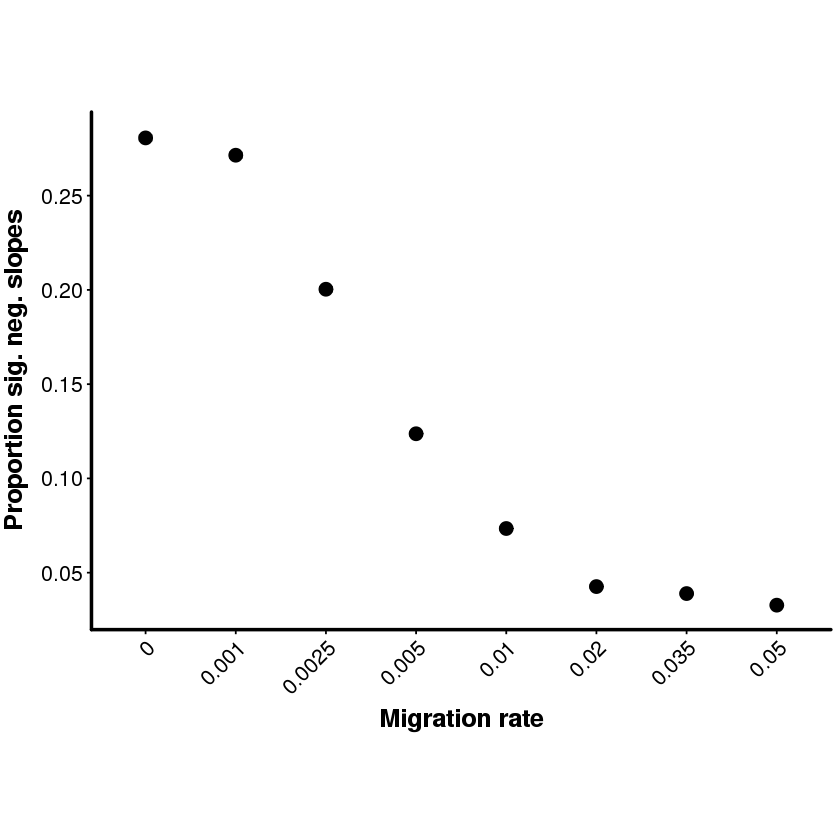

In [10]:
#Plot proportion of significant slopes by migration rate
MigRate_SlopeSum_Melt_Neg <- subset(MigRate_SlopeSum_Melt, variable == "prop_sigNeg")

plotPropSlope_Mig_rate_Neg <- ggplot(MigRate_SlopeSum_Melt_Neg, aes(x = factor(Mig_rate), y = value)) + 
    geom_errorbar(aes(ymin = value - ci.lower, ymax = value + ci.upper), width=0.15, size = 0.7) +
    ylab("Proportion sig. neg. slopes") + xlab("Migration rate") + geom_point(size = 3.5, color = "black") +
    scale_y_continuous(breaks = seq(from = 0, to = 0.30, by = 0.05))
plotPropSlope_Mig_rate_Neg + ng1.45

In [11]:
MigRate_SlopeSum_Melt_Neg

Mig_rate,ci.lower,ci.upper,variable,value
0.0000,0.0012362486,0.0012362486,prop_sigNeg,0.28061943
0.0010,0.0012191871,0.0012191871,prop_sigNeg,0.27143701
0.0025,0.0010970246,0.0010970246,prop_sigNeg,0.20034455
0.0050,0.0009054190,0.0009054190,prop_sigNeg,0.12368357
0.0100,0.0007158691,0.0007158691,prop_sigNeg,0.07341920
0.0200,0.0005545277,0.0005545277,prop_sigNeg,0.04261814
0.0350,0.0005303469,0.0005303469,prop_sigNeg,0.03891131
0.0500,0.0004894909,0.0004894909,prop_sigNeg,0.03275548


In [12]:
#Extrca columns that will be used to create melting dataset for plotting proportion of positive and negative slopes
Bot_SlopeSum_Melt <- dplyr::select(Bot_SlopeSum, bot, prop_sigPos, ci.lower.Pos, ci.upper.Pos, prop_sigNeg,
  ci.lower.Neg, ci.upper.Neg)

#Melt dataframe
dm1 <- melt(Bot_SlopeSum_Melt[,c("bot", "prop_sigPos", "ci.lower.Pos", "ci.upper.Pos")], 
            id=c("bot", "ci.lower.Pos", "ci.upper.Pos"))
dm2 <- melt(Bot_SlopeSum_Melt[,c("bot", "prop_sigNeg", "ci.lower.Neg", "ci.upper.Neg")], 
            id=c("bot", "ci.lower.Neg", "ci.upper.Neg"))

#Rename columns
setnames(dm1, old = c("ci.lower.Pos", "ci.upper.Pos"), new = c("ci.lower", "ci.upper"))
setnames(dm2, old = c("ci.lower.Neg", "ci.upper.Neg"), new = c("ci.lower", "ci.upper"))

#Merge melted dataframes
Bot_SlopeSum_Melt <- rbind(dm1, dm2)

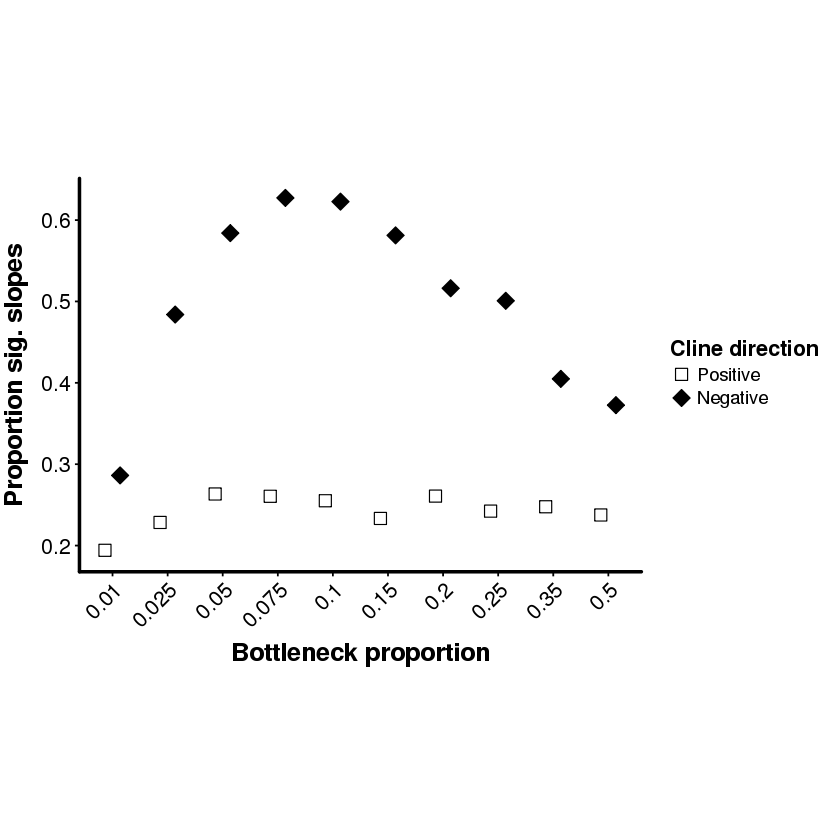

In [33]:
#Plot proportion of significant slopes by migration rate
# Bot_SlopeSum_Melt_Dropped <- subset(Bot_SlopeSum_Melt, bot != 0.01)
plotPropSlope_bot <- ggplot(Bot_SlopeSum_Melt, aes(x = factor(bot), y = value, shape = variable, fill = variable)) + 
    geom_errorbar(aes(ymin = value - ci.lower, ymax = value + ci.upper), width=0.15, size = 0.7, 
    position = position_dodge(width = 0.55)) +
    ylab("Proportion sig. slopes") + xlab("Bottleneck proportion") + geom_point(size = 3.5, color = "black", 
    position = position_dodge(width = 0.55)) +
    scale_shape_manual(labels = c("Positive", "Negative"), values=c(22, 23))+
    scale_fill_manual(labels = c("Positive", "Negative"), values=c("white", "black")) +
    labs(shape = 'Cline direction', fill = 'Cline direction')
plotPropSlope_bot + ng1.45

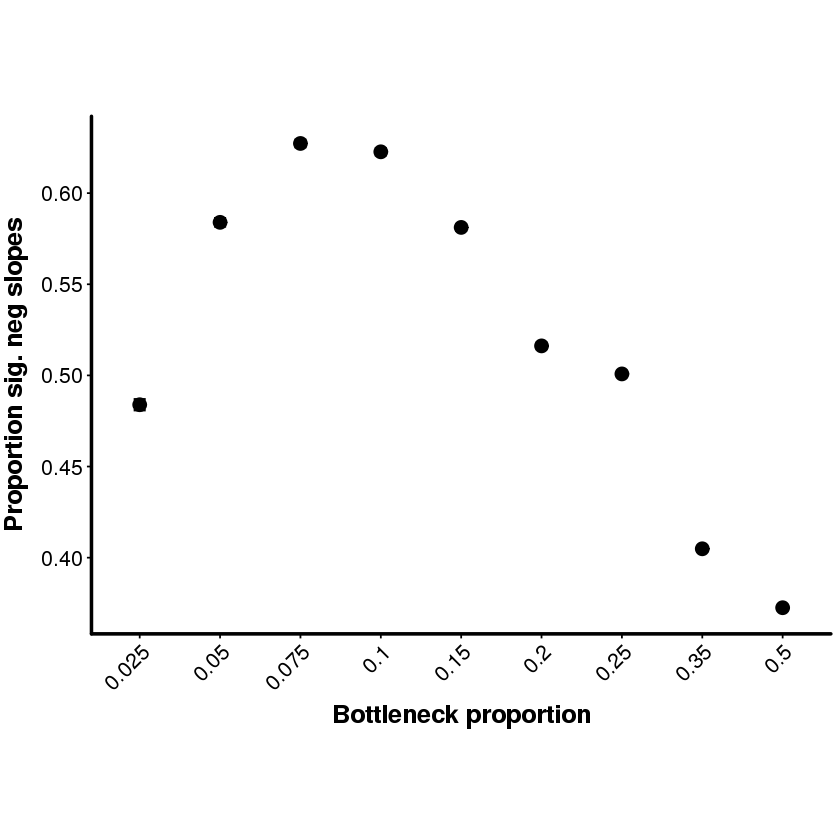

In [14]:
#Plot proportion of significant slopes by migration rate
Bot_SlopeSum_Melt_Dropped_Neg <- subset(Bot_SlopeSum_Melt_Dropped, variable == "prop_sigNeg")

plotPropSlope_bot_Neg <- ggplot(Bot_SlopeSum_Melt_Dropped_Neg, aes(x = factor(bot), y = value)) + 
    geom_errorbar(aes(ymin = value - ci.lower, ymax = value + ci.upper), width=0.15, size = 0.7) +
    ylab("Proportion sig. neg slopes") + xlab("Bottleneck proportion") + geom_point(size = 3.5, color = "black")
plotPropSlope_bot_Neg + ng1.45

### How does the mean slope and proportion of significant clines vary with increasing number of generations since the matrix has filled? Does this differ by migration rate?

Once the matrix is full, there are no more population bottlenecks and HCN frequencies are governed solely by within-population dynamics and migration. Thus we might expect clines to weaken over time due to the constant mixing of alleles every generation (from migration, if included).

Using only clines for which the matrix was full in all 1000 generations, the following three plots show how the mean slope of clines and the proportion of significant clines changes with increasing number of generations since the matrix filled. Lines are colored by migration rate.

#### Main results

1. The mean slope of clines shows little change between the generation where the matrix first filled and the final generation of the simulation. This is true regardless of the migration rate.
2. The proportion of significant clines (both positive and negative) decreases with increasing number of generations since the matrix has filled, but only for the three lowest migration rate values. This is consistant with lower migration rates requiring longer to homogenize allele frequencies, resulting in a gradual decrease in the proportion of significant clines over time. 
3. For the lowest migration rates, the decrease in the proportion of significant clines with increasing generations has not plateaued, suggesting they may continue to decrease even further if given the chance. 

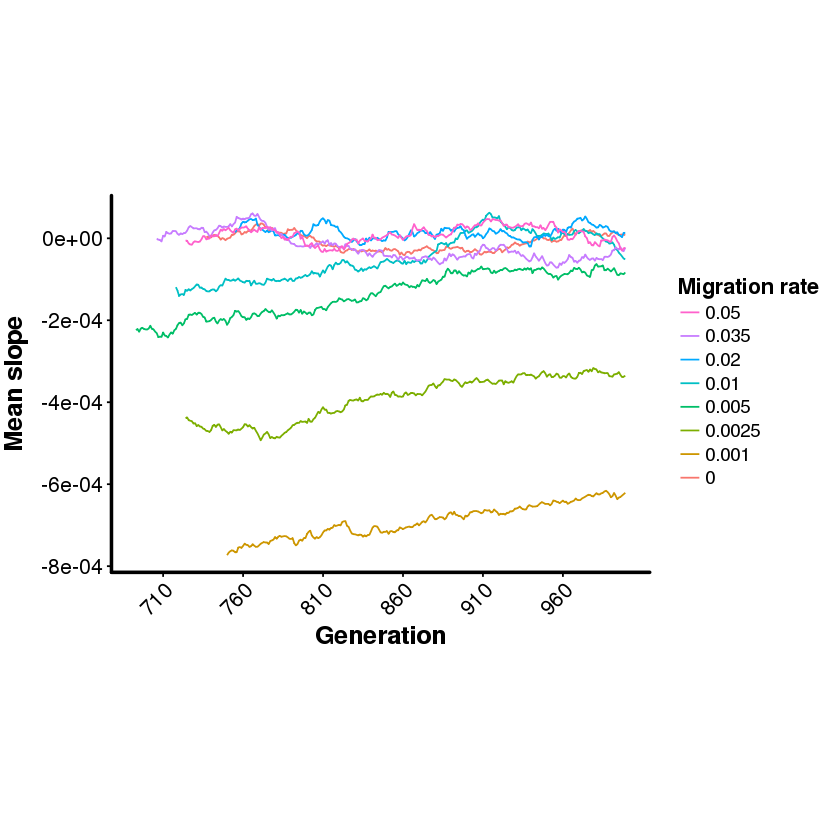

In [15]:
#Subset to start at the generation where the matrix was filled for all 1000 generations
MigRate_SlopeSum_Gen_AllFill <- subset(MigRate_SlopeSum_Gen, n == 1000)

#Plot mean slope by generation number, colored by migration rate
plotMeanSlope_MigRate_Gen <- ggplot(MigRate_SlopeSum_Gen_AllFill, aes(x = Generation, y = mean, 
    group = factor(Mig_rate), color = factor(Mig_rate))) + 
    ylab("Mean slope") + xlab("Generation") + geom_line(size = 0.5, aes(group = factor(Mig_rate), 
    color = factor(Mig_rate))) +
    scale_x_continuous(breaks = seq(from = 310, to = 1000, by = 50)) +
    labs(color = 'Migration rate') +
    guides(color = guide_legend(reverse = TRUE))
plotMeanSlope_MigRate_Gen + ng1.45

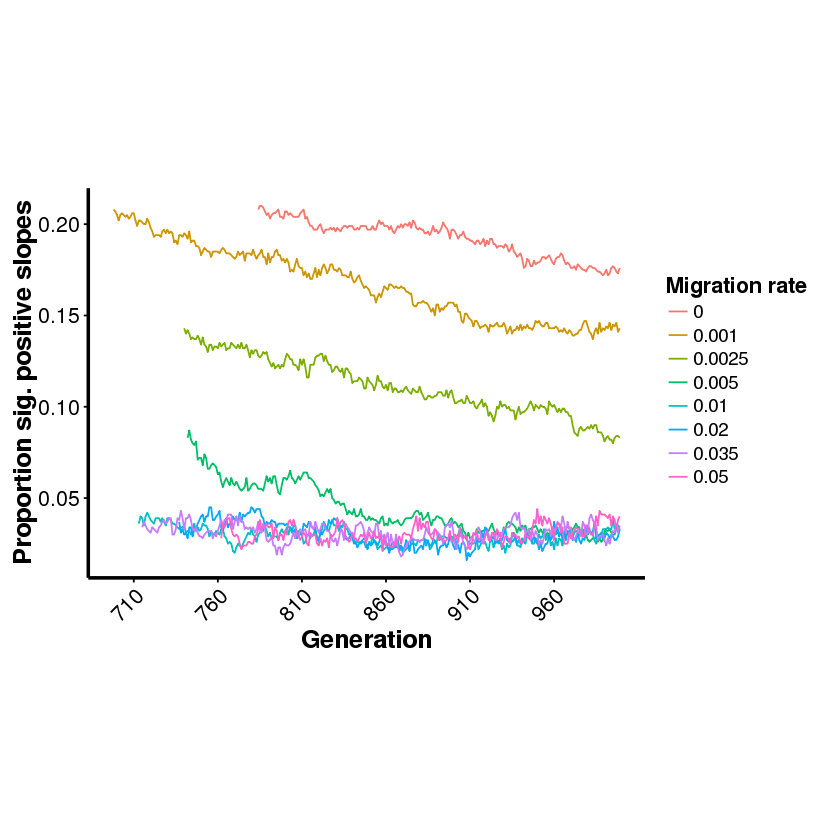

In [10]:
plotPropPos_MigRate_Gen <- ggplot(MigRate_SlopeSum_Gen_AllFill, aes(x = Generation, y = prop_sigPos, 
    group = factor(Mig_rate), color = factor(Mig_rate))) + 
    ylab("Proportion sig. positive slopes") + xlab("Generation") + geom_line(size = 0.5, aes(group = factor(Mig_rate), 
    color = factor(Mig_rate))) +
    scale_x_continuous(breaks = seq(from = 310, to = 1000, by = 50)) +    
    labs(color = 'Migration rate')
plotPropPos_MigRate_Gen + ng1.45

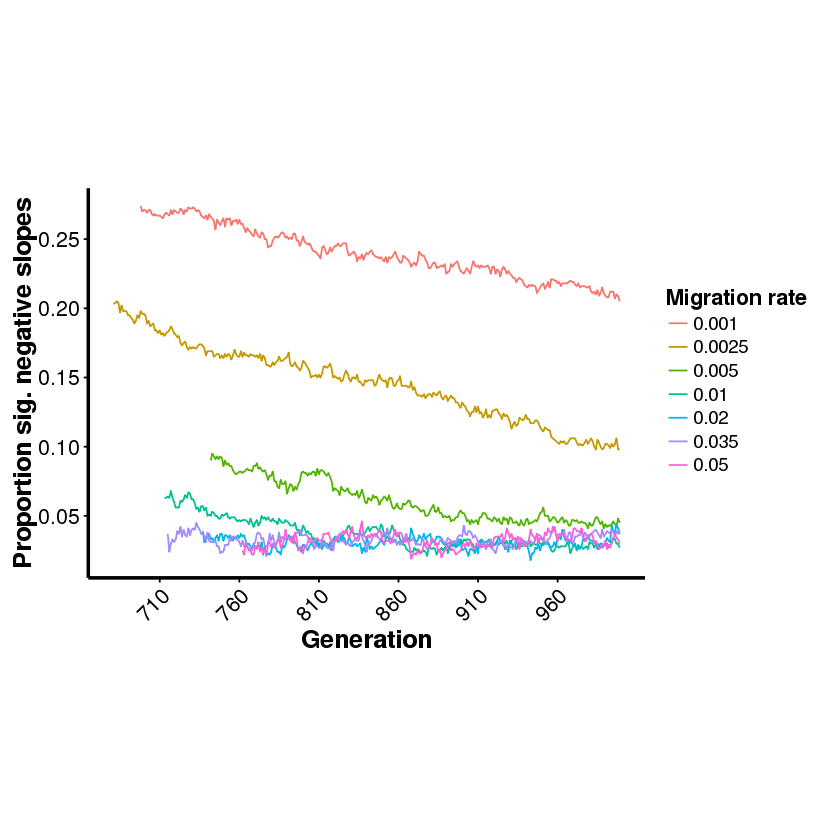

In [42]:
plotPropNeg_MigRate_Gen <- ggplot(MigRate_SlopeSum_Gen_AllFill, aes(x = Generation, y = prop_sigNeg, 
    group = factor(Mig_rate), color = factor(Mig_rate))) + 
    ylab("Proportion sig. negative slopes") + xlab("Generation") + geom_line(size = 0.5, aes(group = factor(Mig_rate), 
    color = factor(Mig_rate))) +
    scale_x_continuous(breaks = seq(from = 310, to = 1000, by = 50)) +
    scale_y_continuous(breaks = seq(from = 0, to = 0.25, by = 0.05)) +
    labs(color = 'Migration rate')
plotPropNeg_MigRate_Gen + ng1.45

### How does the mean slope and proportion of significant clines vary with increasing number of generations since the matrix has filled? Does this differ by bottleneck proportion?

Once the matrix is full, there are no more population bottlenecks and HCN frequencies are governed solely by within-population dynamics (there is no migration when varying the strength of bottlenecks). Given no migration, we would not expect the the clines to disappear following the filling of the matrix. Rather, we might expect that stronger initial bottlenecks produce stronger clines, which are maintained following the filling of the matrix.

Using only clines for which the matrix was full in all 1000 generations, the following three plots show how the mean slope of clines and the proportion of significant clines with increasing number of generations since the matrix filled. Lines are colored by bottleneck strength.

#### Why are the lines of differing lengths?

The lines differ dramatically in length because I am only including generations for which the matrix is filled in all 1000 simulations. The matrix does not fill in the same number of generations every simulation because of stochastic variation having to do with the probability of creating populations. Given that the probability of creating a population is maximized when a population is at carying capacity, and that stronger population bottlenecks (e.g. bottleneck = 0.01) result in greater reductions in population sizes, the matrix fills slower when bottlenecks are stronger. This results in shorter lines for stronger bottleneck values where this stochastic variation is greater.

#### Main results

1. There is little change in the mean slope of clines with increasing time since the matrix has been filled. This does not differ according to the strength of population bottlenecks
2. The proportion of significant positive clines (i.e. increases in HCN across space) decreases with increasing time since the matrix has filled. This effect seems strongest when bottlenecks the bottlenecks that generated the clines were at their weakest (e.g. bottleneck = 1.0).  
3. There is little change in the proportion of significantly negative clines with increasing time since the matrix filled. This is true for att bottleneck strengths.

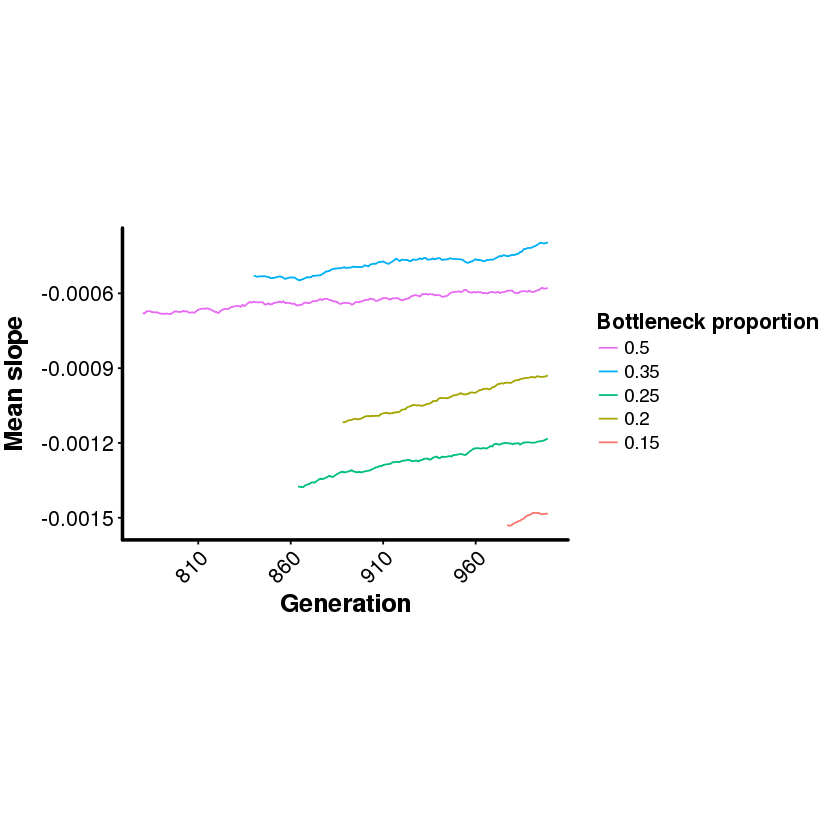

In [34]:
#Subset data to start at generation where matrix is full in all 1000 generations
Bot_SlopeSum_Gen_AllFill <- subset(Bot_SlopeSum_Gen, n == 1000)

#Plot mean slope of clines by generation number, colored by bottleneck proportion
plotMeanSlope_Bot_Gen <- ggplot(Bot_SlopeSum_Gen_AllFill, aes(x = Generation, y = mean, 
    group = factor(bot), color = factor(bot))) + 
    ylab("Mean slope") + xlab("Generation") + geom_line(size = 0.5, aes(group = factor(bot), color = factor(bot))) +
    scale_x_continuous(breaks = seq(from = 310, to = 1000, by = 50)) +
    labs(color = 'Bottleneck proportion') +
    guides(color = guide_legend(reverse = TRUE))
plotMeanSlope_Bot_Gen + ng1.45

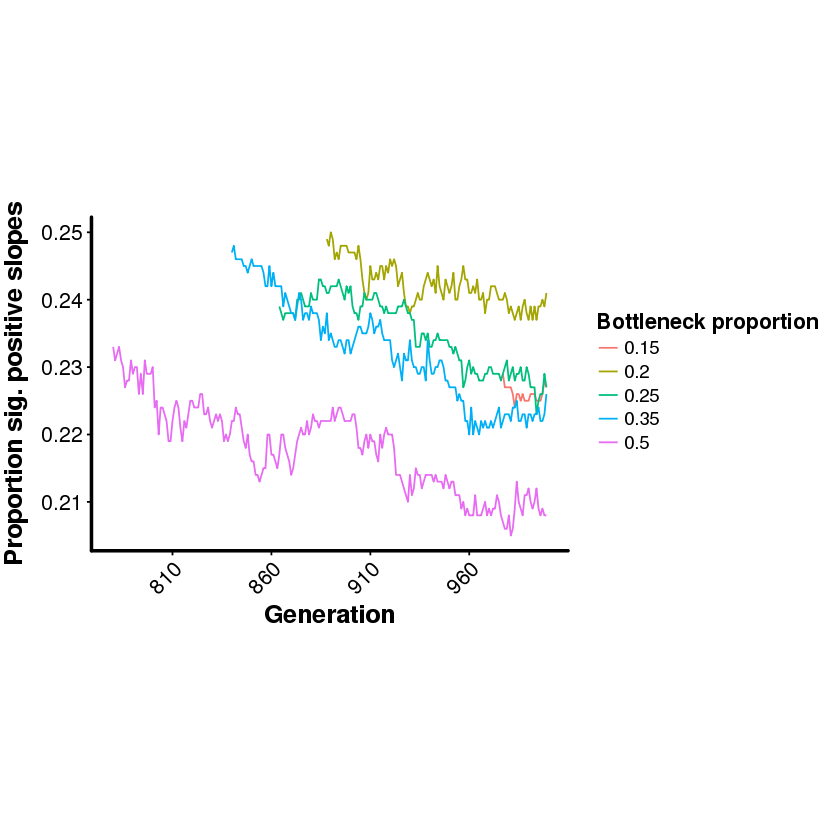

In [35]:
plotPropPos_Bot_Gen <- ggplot(Bot_SlopeSum_Gen_AllFill, aes(x = Generation, y = prop_sigPos, group = factor(bot), 
    color = factor(bot))) + 
    ylab("Proportion sig. positive slopes") + xlab("Generation") + geom_line(size = 0.5, aes(group = factor(bot), 
    color = factor(bot))) +
    scale_x_continuous(breaks = seq(from = 310, to = 1000, by = 50)) +
    labs(color = 'Bottleneck proportion')
plotPropPos_Bot_Gen + ng1.45

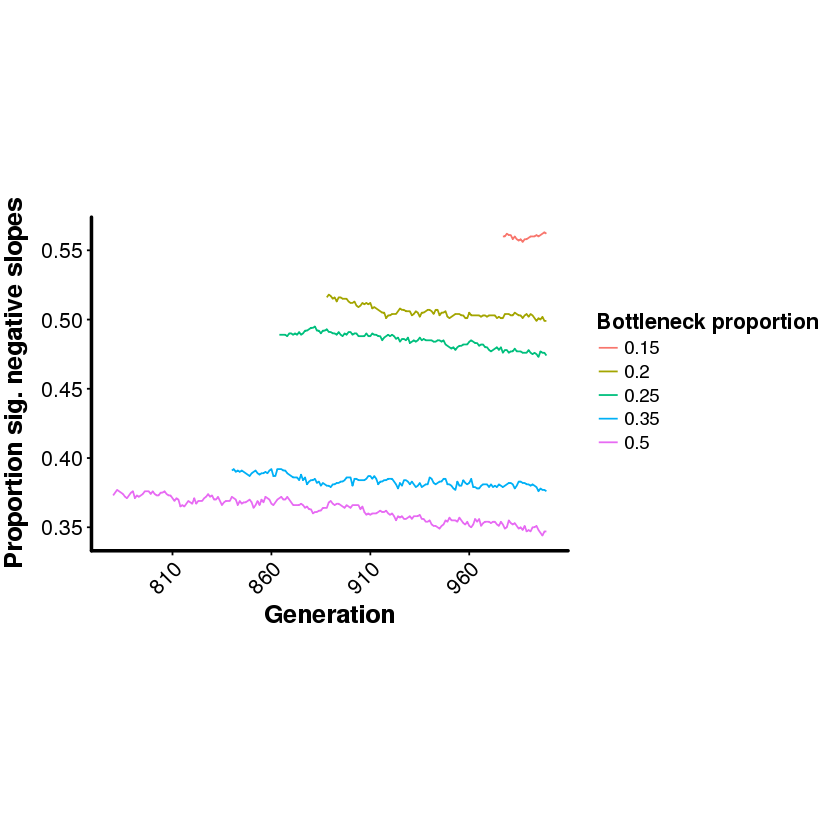

In [36]:
plotPropNeg_Bot_Gen <- ggplot(Bot_SlopeSum_Gen_AllFill, aes(x = Generation, y = prop_sigNeg, group = factor(bot), 
    color = factor(bot))) + 
    ylab("Proportion sig. negative slopes") + xlab("Generation") + geom_line(size = 0.5, aes(group = factor(bot), 
    color = factor(bot))) +
    scale_x_continuous(breaks = seq(from = 310, to = 1000, by = 50)) +
    labs(color = 'Bottleneck proportion')
plotPropNeg_Bot_Gen + ng1.45

### Do we still see evidence of an effect of migration and population bottlenecks on the strength and proportion of significant clines when looking only al the last generation?

Given that populations have had hundreds of generations to "equilibrate" following the filling of the landscape, we might expect the effects of migration and bottlenecks on the strength and proportion of significant clines to disappear over time (there is some evidence that they do for low migration rates, see above). Thus, the following four plots examine the effects of migration and bottlenecks by subsetting to include only the final generation of all simulations. 

#### Main results

1. Patterns generally consistent with those found above with once exception: The proportion of significant negative clines is only greater than the propotion of significant positive clines for the lowest migration value. This is consistent with a gradual decrease in the proportion of significant clines with increasing time since the matrix filled (see above).  

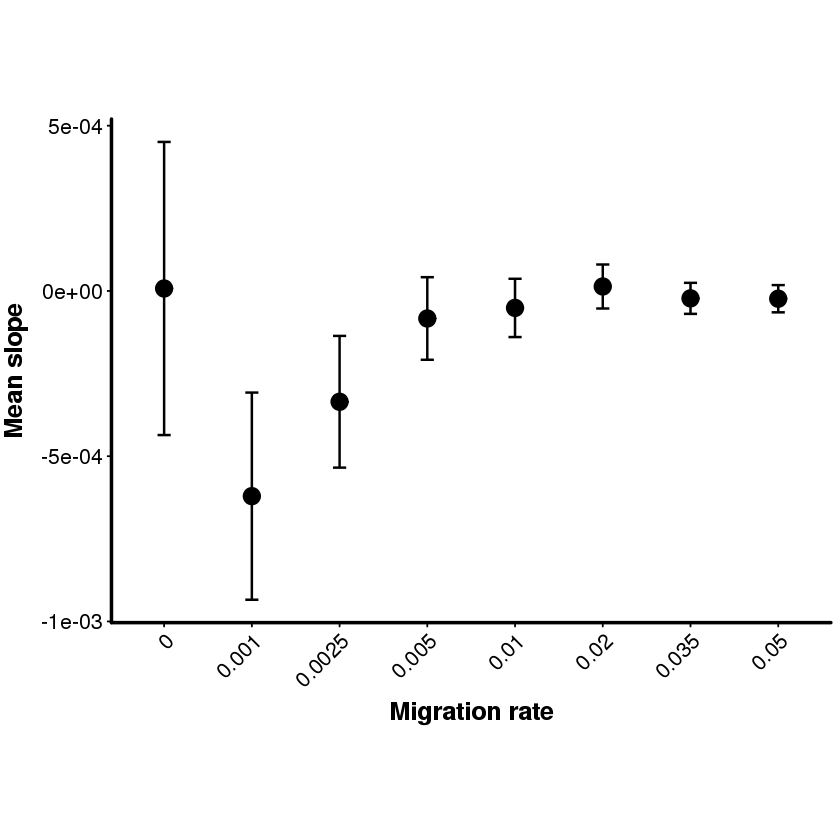

In [37]:
#Subset to include only the last generation
MigRate_SlopeSum_Gen_999 <- subset(MigRate_SlopeSum_Gen, Generation == 999)

#Plot mean slope by migration rate
plotMeanSlope_MigRate_999 <- ggplot(MigRate_SlopeSum_Gen_999, aes(x = factor(Mig_rate), y = mean)) + 
    geom_errorbar(aes(ymin = mean - ci.lower, ymax = mean + ci.upper), width=0.15, size=0.7)+
    ylab("Mean slope") + xlab("Migration rate") + geom_point(size = 4.5, color = "black") 
plotMeanSlope_MigRate_999 + ng1.45

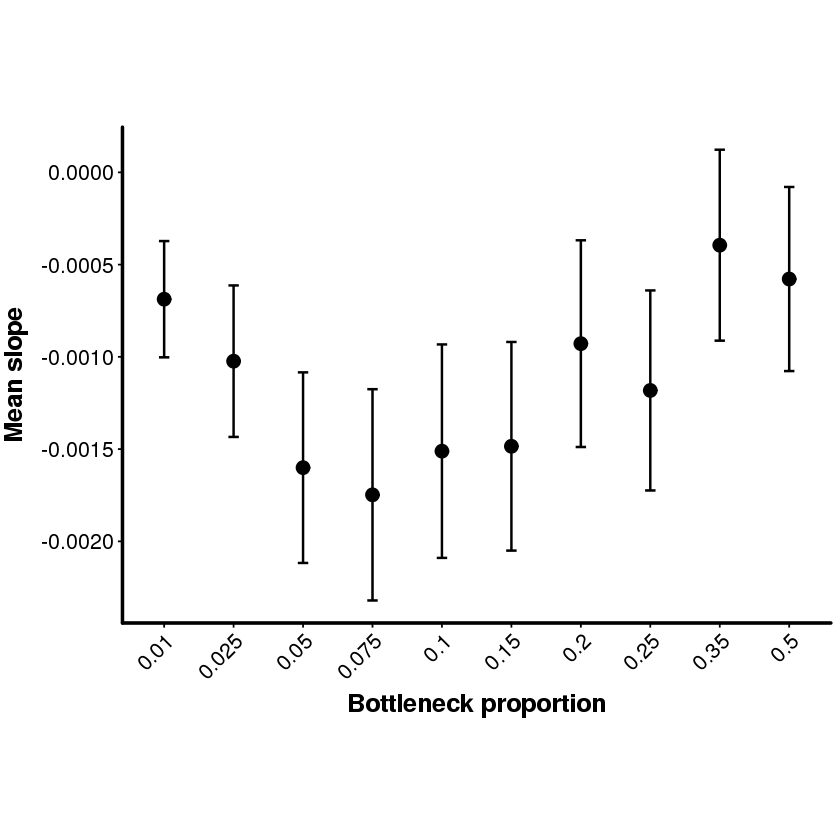

In [38]:
#Subset to include only the last generation
Bot_SlopeSum_Gen_999 <- subset(Bot_SlopeSum_Gen, Generation == 999)

#Plot mean slope by bottleneck proportion
plotMeanSlope_Bot_999 <- ggplot(Bot_SlopeSum_Gen_999, aes(x = factor(bot), y = mean)) + 
    geom_errorbar(aes(ymin = mean - ci.lower, ymax = mean + ci.upper), width=0.15, size=0.7,
    position = position_dodge(width = 0.5))+
    ylab("Mean slope") + xlab("Bottleneck proportion") + geom_point(size = 3.5, color = "black") 
plotMeanSlope_Bot_999 + ng1.45

In [39]:
#Extrca columns that will be used to create melting dataset for plotting proportion of positive and negative slopes
MigRate_SlopeSum_Gen_999_Melt <- dplyr::select(MigRate_SlopeSum_Gen_999, Mig_rate, prop_sigPos, ci.lower.Pos, ci.upper.Pos, prop_sigNeg,
  ci.lower.Neg, ci.upper.Neg)

#Melt dataframe
dm1 <- melt(MigRate_SlopeSum_Gen_999_Melt[,c("Mig_rate", "prop_sigPos", "ci.lower.Pos", "ci.upper.Pos")], 
            id=c("Mig_rate", "ci.lower.Pos", "ci.upper.Pos"))
dm2 <- melt(MigRate_SlopeSum_Gen_999_Melt[,c("Mig_rate", "prop_sigNeg", "ci.lower.Neg", "ci.upper.Neg")], 
            id=c("Mig_rate", "ci.lower.Neg", "ci.upper.Neg"))

#Rename columns
setnames(dm1, old = c("ci.lower.Pos", "ci.upper.Pos"), new = c("ci.lower", "ci.upper"))
setnames(dm2, old = c("ci.lower.Neg", "ci.upper.Neg"), new = c("ci.lower", "ci.upper"))

#Merge melted dataframes
MigRate_SlopeSum_Gen_999_Melt <- rbind(dm1, dm2)

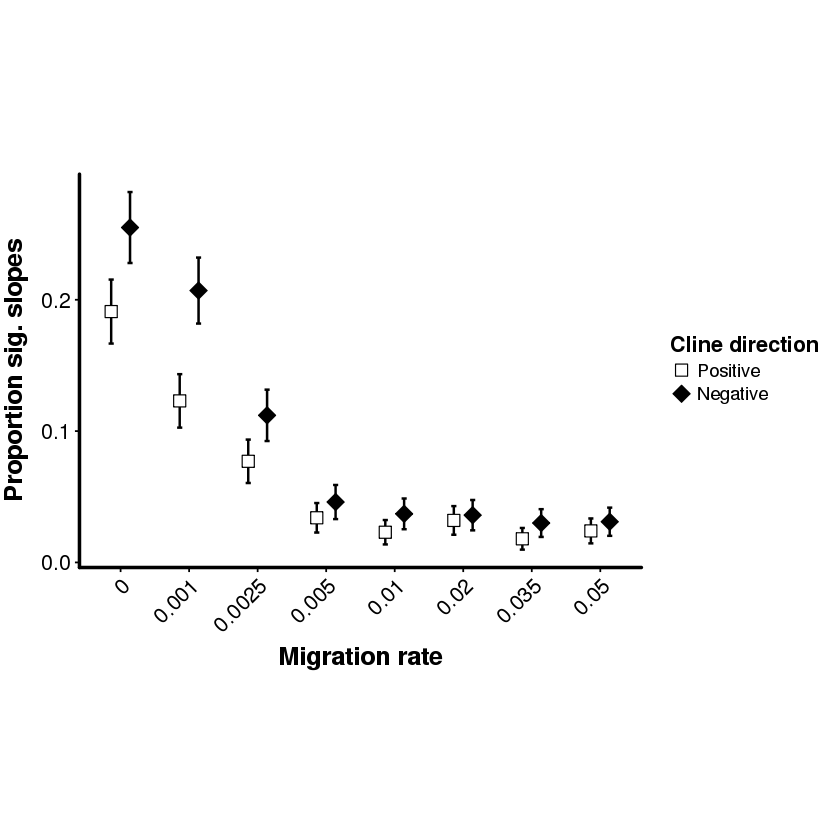

In [40]:
#Plot proportion of significant slopes by migration rate
plotPropSlope_Mig_rate_999 <- ggplot(MigRate_SlopeSum_Gen_999_Melt, aes(x = factor(Mig_rate), y = value, 
    shape = variable,fill = variable)) + 
    geom_errorbar(aes(ymin = value - ci.lower, ymax = value + ci.upper), width=0.15, size = 0.7, 
    position = position_dodge(width = 0.55)) +
    ylab("Proportion sig. slopes") + xlab("Migration rate") + geom_point(size = 3.5, color = "black", 
    position = position_dodge(width = 0.55)) +
    scale_shape_manual(labels = c("Positive", "Negative"),values=c(22, 23))+
    scale_fill_manual(labels = c("Positive", "Negative"),values=c("white", "black")) +
    labs(shape = 'Cline direction', fill = 'Cline direction')
plotPropSlope_Mig_rate_999 + ng1.45

In [41]:
#Extrca columns that will be used to create melting dataset for plotting proportion of positive and negative slopes
Bot_SlopeSum_Melt_Gen_999 <- dplyr::select(Bot_SlopeSum_Gen_999, bot, prop_sigPos, ci.lower.Pos, ci.upper.Pos, prop_sigNeg,
  ci.lower.Neg, ci.upper.Neg)

#Melt dataframe
dm1 <- melt(Bot_SlopeSum_Melt_Gen_999[,c("bot", "prop_sigPos", "ci.lower.Pos", "ci.upper.Pos")], 
            id=c("bot", "ci.lower.Pos", "ci.upper.Pos"))
dm2 <- melt(Bot_SlopeSum_Melt_Gen_999[,c("bot", "prop_sigNeg", "ci.lower.Neg", "ci.upper.Neg")],
            id=c("bot", "ci.lower.Neg", "ci.upper.Neg"))

#Rename columns
setnames(dm1, old = c("ci.lower.Pos", "ci.upper.Pos"), new = c("ci.lower", "ci.upper"))
setnames(dm2, old = c("ci.lower.Neg", "ci.upper.Neg"), new = c("ci.lower", "ci.upper"))

#Merge melted dataframes
Bot_SlopeSum_Melt_Gen_999 <- rbind(dm1, dm2)

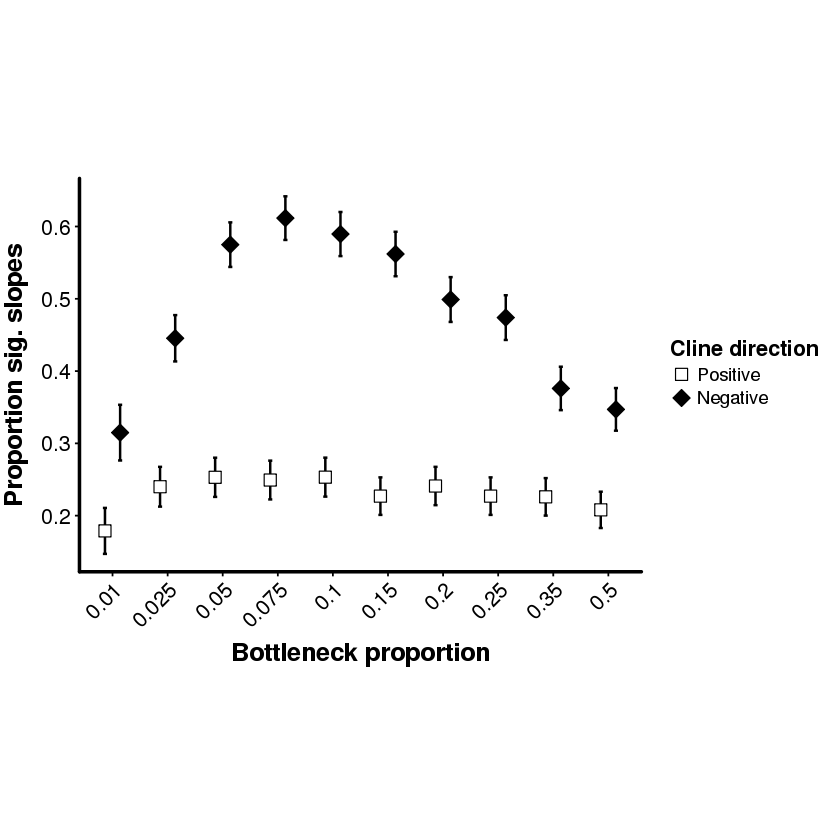

In [42]:
#Plot proportion of significant slopes by migration rate
plotPropSlope_bot_999 <- ggplot(Bot_SlopeSum_Melt_Gen_999, aes(x = factor(bot), y = value, shape = variable, 
    fill = variable)) + 
    geom_errorbar(aes(ymin = value - ci.lower, ymax = value + ci.upper), width=0.15, size = 0.7, 
    position = position_dodge(width = 0.55)) +
    ylab("Proportion sig. slopes") + xlab("Bottleneck proportion") + geom_point(size = 3.5, color = "black", 
    position = position_dodge(width = 0.55)) +
    scale_shape_manual(labels = c("Positive", "Negative"),values=c(22, 23))+
    scale_fill_manual(labels = c("Positive", "Negative"),values=c("white", "black")) +
    labs(shape = 'Cline direction', fill = 'Cline direction')
plotPropSlope_bot_999 + ng1.45

In [16]:
path = "/scratch/research/projects/trifolium/SEC_Simulation.Evolutionary.Clines/SEC_Sync/SEC_Figures/Drift.Migration/Mig_Bot_Vary"

# p1 <- plotPropSlope_Mig_rate + ng1.45
# p2 <- plotPropSlope_bot + ng1.45
# p3 <- plotNe_bot + ng1.45
# p4 <- plotNe_bot_Red + ng1.45
p5 <- plotPropSlope_Mig_rate_Neg + ng1.45
p6 <- plotPropSlope_bot_Neg + ng1.45

# ggsave("PropSlope_x_MigRate.pdf", plot = p1, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
# ggsave("PropSlope_x_bot.pdf", plot = p2, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
# ggsave("PropNe_x_bot.pdf", plot = p3, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
# ggsave("PropNe_x_bot_Red.pdf", plot = p4, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
ggsave("PropNeg_x_mig.pdf", plot = p5, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)
ggsave("PropNeg_x_bot.pdf", plot = p6, device = "pdf", width = 6.0, height = 6.0, path = path, dpi = 600)


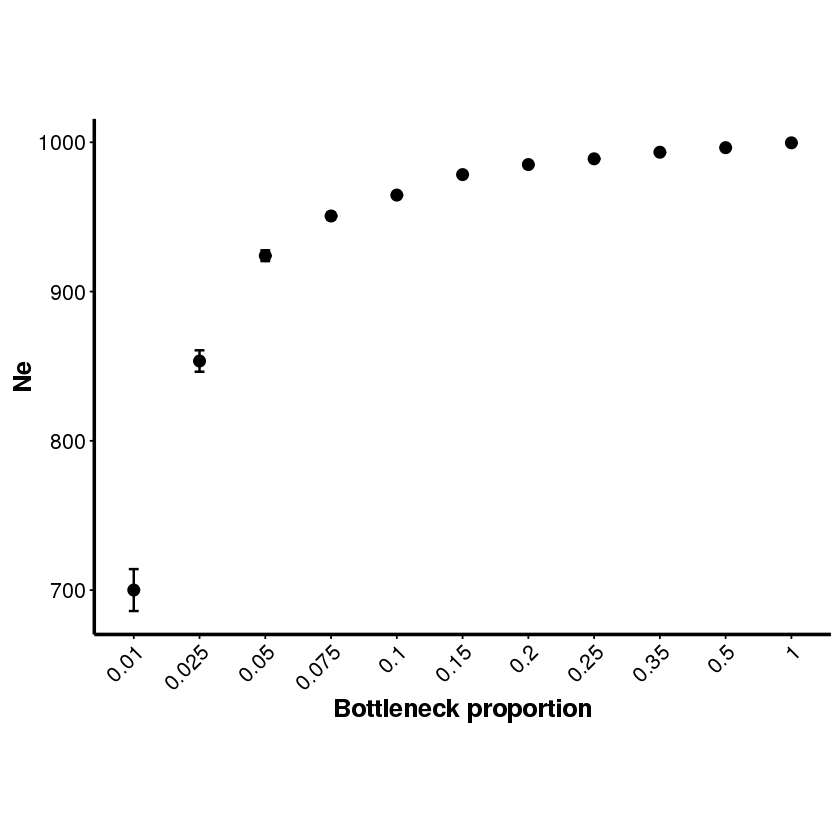

In [4]:
BotNe <- summarySE(Bot_Ne, groupvars = "bot", measurevar = "Ne")
plotNe_bot <- ggplot(BotNe, aes(x = factor(bot), y = Ne)) + 
  geom_errorbar(aes(ymin=Ne-se,ymax=Ne+se),width=0.15,size=0.7) +
  ylab("Ne")+xlab("Bottleneck proportion")+
  geom_point(size=3)
plotNe_bot + ng1.45

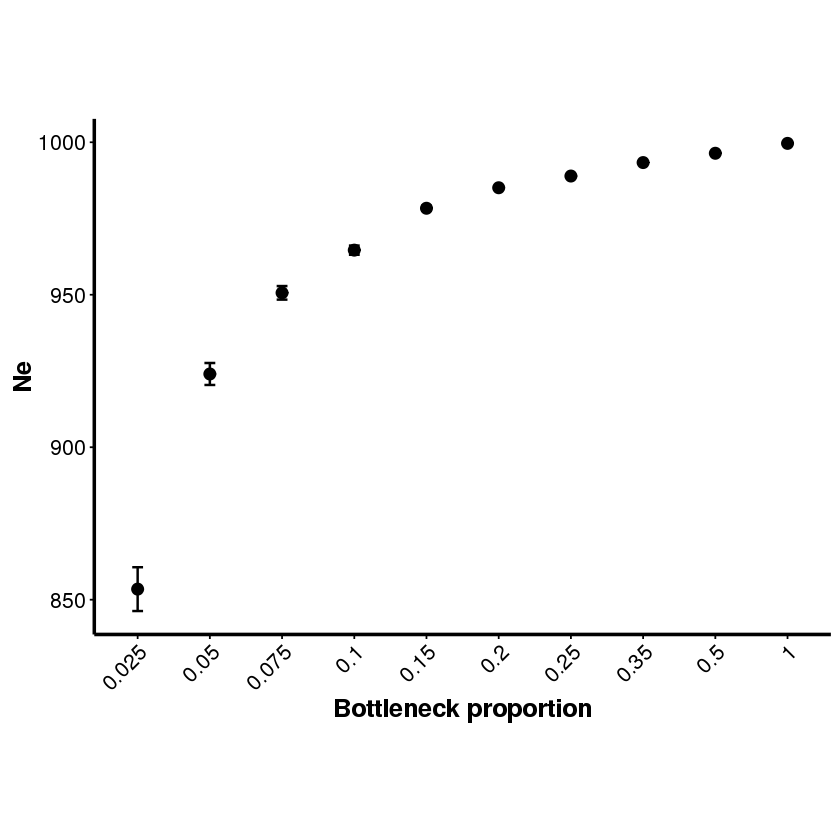

In [6]:
BotNe_Reduced <- subset(BotNe, bot != 0.01)
plotNe_bot_Red <- ggplot(BotNe_Reduced, aes(x = factor(bot), y = Ne)) + 
  geom_errorbar(aes(ymin=Ne-se,ymax=Ne+se),width=0.15,size=0.7) +
  ylab("Ne")+xlab("Bottleneck proportion")+
  geom_point(size=3)
plotNe_bot_Red + ng1.45